In [20]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.tri as tri
import seaborn as sns
import numpy as np
import pandas as pd
import pickle
import scipy.io as io

import torch

from sbi.analysis import pairplot

from openTSNE import TSNE

# load and read nwb files
from pynwb import NWBHDF5IO

from ephys_utils import get_time_voltage_current_currindex0, syn_current

In [4]:
# remove top and right axis from plots
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

In [5]:
def adjust_spines(ax, spines, spine_pos=5, color='k', linewidth=None, smart_bounds=True):
    """Convenience function to adjust plot axis spines."""

    # If no spines are given, make everything invisible
    if spines is None:
        ax.axis('off')
        return

    for loc, spine in ax.spines.items():
        if loc in spines:
            spine.set_position(('outward', spine_pos))  # outward by x points
            #spine.set_smart_bounds(smart_bounds)
            spine.set_color(color)
            if linewidth is not None:
                spine.set_linewidth = linewidth
        else:
            spine.set_visible(False)  # make spine invisible
            # spine.set_color('none')  # this will interfere w constrained plot layout

    # Turn off ticks where there is no spine
    if 'left' in spines:
        ax.yaxis.set_ticks_position('left')
    else:
        # No visible yaxis ticks and tick labels
        # ax.yaxis.set_visible(False)  # hides whole axis, incl. ax label
        # ax.yaxis.set_ticks([])  # for shared axes, this would delete ticks for all
        plt.setp(ax.get_yticklabels(), visible=False)  # hides ticklabels but not ticks
        plt.setp(ax.yaxis.get_ticklines(), color='none')  # changes tick color to none
        # ax.tick_params(axis='y', colors='none')  # (same as above) changes tick color to none

    if 'bottom' in spines:
        ax.xaxis.set_ticks_position('bottom')
    else:
        # No visible xaxis ticks and tick labels
        # ax.xaxis.set_visible(False)  # hides whole axis, incl. ax label
        # ax.xaxis.set_ticks([])  # for shared axes, this would  delete ticks for all
        plt.setp(ax.get_xticklabels(), visible=False)  # hides ticklabels but not ticks
        plt.setp(ax.xaxis.get_ticklines(), color='none')  # changes tick color to none

### Load observed data

In [9]:
M1_25degree = pickle.load(open('pickles/M1_features.pickle', 'rb'))
ephys_features = np.array(M1_25degree['X_o'].columns)[:-4]
Xo = M1_25degree['X_o'].copy()
feature_list=range(23)

In [10]:
prop = pd.read_csv('../data/m1_patchseq_meta_data.csv', sep = '\t')
prop = prop.rename(columns = {'Targeted layer': 'Layer'})
prop = prop[['Cell', 'Layer', 'Cre', 'RNA type']]
prop = prop.set_index('Cell')
prop=prop.reindex(Xo.index)
no_low_qual=np.array(list(map(str,prop['RNA type'].values)))!='nan'
prop=prop.loc[no_low_qual,:]
Xo = Xo.loc[no_low_qual,:]
celltypes=prop['RNA type']

In [11]:
annotations = pd.read_csv('../data/cluster.annotation.csv',index_col=0)
cellTypeColors={}
for celltype in np.unique(annotations['cluster_label'].values):
    cellTypeColors.update({celltype:annotations.iloc[np.where(annotations['cluster_label']==celltype)[0][0],:]\
                          ['cluster_color']})
colors=np.array([cellTypeColors[celltype] for celltype in celltypes])

In [12]:
model_param_names = np.array(['C', r'$R_{input}$', r'$\tau$', r'$g_{Nat}$', r'$g_{Na}$', r'$g_{Kd}$', r'$g_{M}$',
                         r'$g_{Kv31}$', r'$g_{L}$', r'$E_{leak}$', r'$\tau_{max}$', 'VT', r'$r_{SS}$'])
prior_min = [0.1,  20,  0.1,    0,        0,      0,      0,      0,      0, -130,    50,    -90,   0.1]
prior_max = [15,   1000,   70,   250,     100,      30,    3,     250,     3,  -50,  4000,   -35,    3]

In [13]:
# Vip
celltype_Vip = (celltypes=='Vip C1ql1') | (celltypes=='Vip Chat_1') | (celltypes=='Vip Gpc3') | \
            (celltypes=='Vip Htr1f') | (celltypes=='Vip Mybpc1_1') | (celltypes=='Vip Mybpc1_2') | \
            (celltypes=='Vip Mybpc1_3') | (celltypes=='Vip Serpinf1_1') | (celltypes=='Vip Serpinf1_2') | \
            (celltypes=='Vip Serpinf1_3') | (celltypes=='Vip Sncg')

# Sst
celltype_Sst = (celltypes=='Sst C1ql3_1') | (celltypes=='Sst C1ql3_2') | (celltypes=='Sst Calb2') | \
       (celltypes=='Sst Chodl') | (celltypes=='Sst Crhr2_1') | (celltypes=='Sst Crhr2_2') | \
       (celltypes=='Sst Etv1') | (celltypes=='Sst Hpse') | (celltypes=='Sst Htr1a') | \
       (celltypes=='Sst Myh8_1') | (celltypes=='Sst Myh8_2') | (celltypes=='Sst Myh8_3') | \
       (celltypes=='Sst Penk') | (celltypes=='Sst Pvalb Calb2') | (celltypes=='Sst Pvalb Etv1') | \
       (celltypes=='Sst Tac2') | (celltypes=='Sst Th_1') | (celltypes=='Sst Th_3')

# Lamp5
celltype_Lamp5 = (celltypes=='Lamp5 Egln3_1') | (celltypes=='Lamp5 Egln3_2') | (celltypes=='Lamp5 Lhx6') | \
            (celltypes=='Lamp5 Pax6') | (celltypes=='Lamp5 Pdlim5_1') | (celltypes=='Lamp5 Pdlim5_2') | \
            (celltypes=='Lamp5 Slc35d3')

# Pvalb
celltype_Pvalb = (celltypes=='Pvalb Calb1_1') | (celltypes=='Pvalb Calb1_2') | (celltypes=='Pvalb Egfem1') | \
       (celltypes=='Pvalb Gabrg1') | (celltypes=='Pvalb Gpr149') | (celltypes=='Pvalb Il1rapl2') | \
       (celltypes=='Pvalb Kank4') | (celltypes=='Pvalb Reln') | (celltypes=='Pvalb Vipr2_2')

# Pyramidal
celltype_Pyr = (celltypes=='L2/3 IT_3') | (celltypes=='L4/5 IT_1') | (celltypes=='L4/5 IT_2') | \
           (celltypes=='L5 ET_1') | (celltypes=='L5 ET_2') | (celltypes=='L5 ET_3') | \
           (celltypes=='L5 ET_4') | (celltypes=='L5 IT_1') | (celltypes=='L5 IT_2') | \
           (celltypes=='L5 IT_3') | (celltypes=='L5 IT_4') | (celltypes=='L5/6 NP CT') | \
           (celltypes=='L5/6 NP_1') | (celltypes=='L5/6 NP_2') | (celltypes=='L6 CT Cpa6') | \
           (celltypes=='L6 CT Grp') | (celltypes=='L6 CT Pou3f2') | (celltypes=='L6 IT_1') | \
           (celltypes=='L6 IT_2') | (celltypes=='L6b Col6a1') | (celltypes=='L6b Kcnip1') | \
           (celltypes=='L6b Ror1') | (celltypes=='L6b Shisa6_1') | (celltypes=='L6b Shisa6_2')
# Sncg
celltype_Sncg = (celltypes=='Sncg Calb1_2') | (celltypes=='Sncg Npy2r') | (celltypes=='Sncg Calb1_1') | \
                (celltypes=='Sncg Col14a1')

Some numbers to report in the manuscript:

In [14]:
sum(celltype_Pyr)

278

In [15]:
sum(celltype_Sst)

240

In [16]:
sum(celltype_Vip)

54

In [17]:
sum(celltype_Sncg)

11

In [18]:
sum(celltype_Pvalb)

289

In [19]:
sum(celltype_Vip) + sum(celltype_Sst) + sum(celltype_Lamp5) + sum(celltype_Pvalb) + sum(celltype_Sncg)

677

### Figure 1a

Illustrate model mismatch

In [21]:
# with open('pickles/training_flows_specifics.pickle', 'rb') as f:
#     training_flows_specifics = pickle.load(f)

In [22]:
# ind=training_flows_specifics['ind']

In [23]:
dir_locs=[]
for cell_name in Xo.index:
    dir_locs.append(np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]])

In [26]:
# import os
# # Load all raw data directory locations
# dir_locs = []
# for root, dirs, files in os.walk('../M1/data/'):
#     if files:
#         for file in files:
#             if file.endswith('.mat'):
#                 dir_locs.append(root + '/' + file)
# dir_locs=np.array(dir_locs)[M1_25degree['exclude']][no_low_qual]

Pick example cell

In [27]:
cell_name = '20180529_sample_3'

In [28]:
#Check whether raw file name corresponds to the cell's name
data = np.array(M1_25degree['M1_names'])[no_low_qual][np.where(Xo.index==cell_name)[0][0]]
data

'../data/raw_data/000008/sub-mouse-PAIFP/sub-mouse-PAIFP_ses-20180529-sample-3_slice-20180529-slice-3_cell-20180529-sample-3_icephys.nwb'

In [29]:
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore")
    data = NWBHDF5IO(data, 'r', load_namespaces=True).read()

In [30]:
xo=Xo.loc[cell_name,:].iloc[:-4].values
feature_list=range(23)

In [31]:
time_obs, voltage_obs, current_obs, curr_index_0_obs = get_time_voltage_current_currindex0(data)
liquid_junction_potential=15.4
voltage_obs-=liquid_junction_potential

I, t_on, t_off, dt, t, A_soma = syn_current(area=Xo.loc[cell_name, '1-comp area'], curr_level=3e-4)
curr_index = np.where(current_obs==300)[0][0]
observation = {'data': voltage_obs[:20000, curr_index], 'time': time_obs[:20000]*1e3, 'dt':4*1e-5*1e3, 'I': I}

In [183]:
lw=2

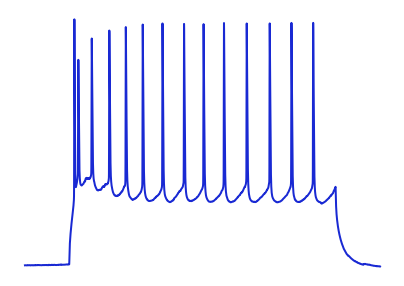

In [184]:
fig, ax_obs = plt.subplots(1,1, figsize=(7,5))
# Experimental observation
ax_obs.plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
sns.despine(left=True, bottom=True, ax=ax_obs)
ax_obs.set_xticks([])
ax_obs.set_yticks([])
plt.savefig('../figures/preliminary/observation_example.png', bbox_inches = 'tight', pad_inches = 0, dpi=500)

In [35]:
# load prior simulations
theta=np.load('./save_sims/M1_chunks/full_batch.npz')['theta']
stats=np.load('./save_sims/M1_chunks/full_batch.npz')['stats']
keeping=(~np.isnan(np.mean(stats, axis=1)))&(~np.isinf(np.mean(stats, axis=1))) # delete non-spiking simulations
stats=stats[keeping,:]
theta=theta[keeping,:]

tcmalloc: large alloc 1380007936 bytes == 0x40bd4000 @ 


In [17]:
# # load prior simulations from model without rSS parameter (for suppl figure)
# theta_without_rSS=np.load('./without_rSS/save_sims/M1_chunks/full_batch.npz')['theta']
# stats_without_rSS=np.load('./without_rSS/save_sims/M1_chunks/full_batch.npz')['stats']
# keeping=(~np.isnan(np.mean(stats_without_rSS, axis=1)))&(~np.isinf(np.mean(stats_without_rSS, axis=1))) # delete non-spiking simulations
# stats_without_rSS=stats_without_rSS[keeping,:]
# theta_without_rSS=theta_without_rSS[keeping,:]

tcmalloc: large alloc 1380007936 bytes == 0xc65c4000 @ 


In [36]:
# find 1000 prior simulations closest to the experimental observation in terms of Z-scored ephys distance
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances=np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(xo[feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]

tcmalloc: large alloc 1316626432 bytes == 0xbdd08000 @ 


In [37]:
# # same but for model without rSS parameter
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_without_rSS=np.sort(
#     np.sqrt(
#         np.sum(
#             (
#                 (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                 -(xo[feature_list]-s_mean)/s_std
#             )**2,axis=1
#         )
#     )
# )[0:1000]

Next block takes a while. If performed once, you don't need to run it again and can just go to 2nd next block.

In [38]:
# now do it for all experimental observations
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_observations=[]
for i in range(Xo.shape[0]):
    if i%10==0:
        print(i,' ', end='')
    E_distances_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(Xo.values[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_observations.append(E_distances_one)
E_distances_observations=np.array(E_distances_observations)
np.savez('./save_sims/E_distances_observations.npz',
     distances=E_distances_observations
        )

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890  900  910  920  930  940  950  

In [39]:
# # same but for model without rSS parameter
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_observations=[]
# for i in range(Xo.shape[0]):
#     if i%10==0:
#         print(i,' ', end='')
#     E_distances_one=np.sort(
#         np.sqrt(
#             np.sum(
#                 (
#                     (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                     -(Xo.values[i,feature_list]-s_mean)/s_std
#                 )**2,axis=1
#             )
#         )
#     )[0:1000]
#     E_distances_observations.append(E_distances_one)
# E_distances_observations=np.array(E_distances_observations)
# np.savez('without_rSS/save_sims/E_distances_observations.npz',
#      distances=E_distances_observations
#         )

Next block takes a while. If performed once, you don't need to run it again and can just go to the next block.

In [40]:
# pick 1000 random prior simulations and perform for each of them an analogous analysis
selected_random_sims=np.random.randint(0,stats.shape[0],1000)
stats_picked=stats[selected_random_sims,:]
E_distances_prior=[]
for i in range(1000):
    if i%10==0:
        print(i,' ', end='')
    E_distances_prior_one=np.sort(
        np.sqrt(
            np.sum(
                (
                    (stats[:,feature_list]-s_mean)/s_std
                    -(stats_picked[i,feature_list]-s_mean)/s_std
                )**2,axis=1
            )
        )
    )[0:1000]
    E_distances_prior.append(E_distances_prior_one)
E_distances_prior=np.array(E_distances_prior)
np.savez('./save_sims/E_distances_prior.npz',
     distances=E_distances_prior,
     indices=selected_random_sims
    )

0  10  20  30  40  50  60  70  80  90  100  110  120  130  140  150  160  170  180  190  200  210  220  230  240  250  260  270  280  290  300  310  320  330  340  350  360  370  380  390  400  410  420  430  440  450  460  470  480  490  500  510  520  530  540  550  560  570  580  590  600  610  620  630  640  650  660  670  680  690  700  710  720  730  740  750  760  770  780  790  800  810  820  830  840  850  860  870  880  890  900  910  920  930  940  950  960  970  980  990  

In [44]:
E_distances_prior=np.load('./save_sims/E_distances_prior.npz')['distances']
E_distances_prior_indices=np.load('./save_sims/E_distances_prior.npz')['indices']
E_distances_observations=np.load('./save_sims/E_distances_observations.npz')['distances']
#E_distances_observations_without_rSS=np.load('without_rSS/save_sims/E_distances_observations.npz')['distances']

In [45]:
from simulator import EphysModel
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=280,
                   save_chunks=True)

In [46]:
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_indexes=np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(xo[feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]
x_prior = M1_model._run_HH_model(theta[E_distances_indexes[[1,100,500]],:])

In [42]:
# from without_rSS.simulator import EphysModel
# M1_model=EphysModel(name='M1',
#                    T=25.0,
#                    E_Na=69.0,
#                    E_K=-98.4,
#                    E_Ca=127.2,
#                    start=100,
#                    end=700,
#                    dt=0.04,
#                    n_processes=40,
#                    noise_factor=10,
#                    use_pathos=True,
#                    chunk_size=280,
#                    save_chunks=True)

In [43]:
# s_mean=stats_without_rSS[:,feature_list].mean(axis=0)
# s_std=stats_without_rSS[:,feature_list].std(axis=0)
# E_distances_indexes_without_rSS=np.argsort(
#     np.sqrt(
#         np.sum(
#             (
#                 (stats_without_rSS[:,feature_list]-s_mean)/s_std
#                 -(xo[feature_list]-s_mean)/s_std
#             )**2,axis=1
#         )
#     )
# )[0:1000]

# x_prior_without_rSS = M1_model._run_HH_model(theta_without_rSS[E_distances_indexes_without_rSS[[1,100,500]],:])

In [47]:
# from simulator import EphysModel
# M1_model=EphysModel(name='M1',
#                    T=25.0,
#                    E_Na=69.0,
#                    E_K=-98.4,
#                    E_Ca=127.2,
#                    start=100,
#                    end=700,
#                    dt=0.04,
#                    n_processes=40,
#                    noise_factor=10,
#                    use_pathos=True,
#                    chunk_size=280,
#                    save_chunks=True)

In [185]:
sim_ind_ex=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[round(E_distances_prior.shape[0]//2.2)]]

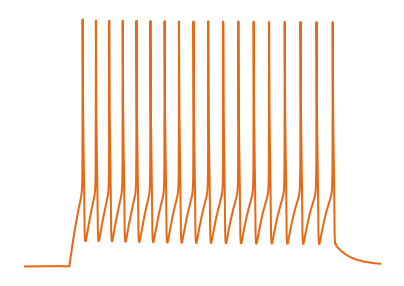

In [186]:
fig, ax_sim = plt.subplots(1,1, figsize=(7,5))
# Prior simulation
x_prior_example=M1_model._run_HH_model(theta[sim_ind_ex,:])
ax_sim.plot(x_prior_example['time'], x_prior_example['data'][0,0,:], c='#e66913ff', lw=lw)
sns.despine(left=True, bottom=True, ax=ax_sim)
ax_sim.set_xticks([])
ax_sim.set_yticks([])
plt.savefig('../figures/preliminary/simulation_example.png', bbox_inches = 'tight', pad_inches = 0, dpi=500)

In [69]:
# find 1000 prior simulations closest to a simulation in terms of Z-scored ephys distance
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_ex=np.sort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(stats[sim_ind_ex,feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]

In [70]:
s_mean=stats[:,feature_list].mean(axis=0)
s_std=stats[:,feature_list].std(axis=0)
E_distances_ex_indexes=np.argsort(
    np.sqrt(
        np.sum(
            (
                (stats[:,feature_list]-s_mean)/s_std
                -(stats[sim_ind_ex,feature_list]-s_mean)/s_std
            )**2,axis=1
        )
    )
)[0:1000]
x_sim_prior = M1_model._run_HH_model(theta[E_distances_ex_indexes[[1,100,500]],:])

In [71]:
x_sim_ex = M1_model._run_HH_model(theta[sim_ind_ex,:])

In [72]:
fancy_colors = np.array(
    [
        [86, 100, 26], [192, 175, 251], [230, 161, 118],
        [0, 103, 138], [152, 68, 100], [94, 204, 171], 
        [205, 205, 205]
    ]
)/255

In [73]:
def create_figure_1c(fig):
    # Fig. 1: illustrate model mismatch (mm)
    
    if fig is None:
        fig = plt.figure(figsize=(14, 8))
    else: fig = fig
    
    width=.14 # for membrane voltage traces
    height=.45 # for membrane voltage traces
    ax_mm_banana=plt.axes([0,0.15,.36,.8])
    axes_ex_1=np.array([plt.axes([x,.50,width,height]) for x in [.41,.56,.71,.86]])
    axes_ex_2=np.array([plt.axes([x,0.1,width,height]) for x in [.41,.56,.71,.86]])
    
    return ax_mm_banana, axes_ex_1, axes_ex_2

In [74]:
# def create_suppl_figure_1(fig):
#     # Suppl. Fig. 1: illustrate model mismatch including a model for which we don't introduce rSS
    
#     if fig is None:
#         fig = plt.figure(figsize=(14, 12))
#     else: fig = fig
    
#     width=.14 # for membrane voltage traces
#     height=.22 # for membrane voltage traces
#     ax_mm_banana=plt.axes([0,0.15,.36,.8])
#     axes_ex_1=np.array([plt.axes([x,.7,width,height]) for x in [.41,.56,.71,.86]])
#     axes_ex_2=np.array([plt.axes([x,0.4,width,height]) for x in [.41,.56,.71,.86]])
#     axes_ex_3=np.array([plt.axes([x,0.1,width,height]) for x in [.41,.56,.71,.86]])
    
#     return ax_mm_banana, axes_ex_1, axes_ex_2, axes_ex_3

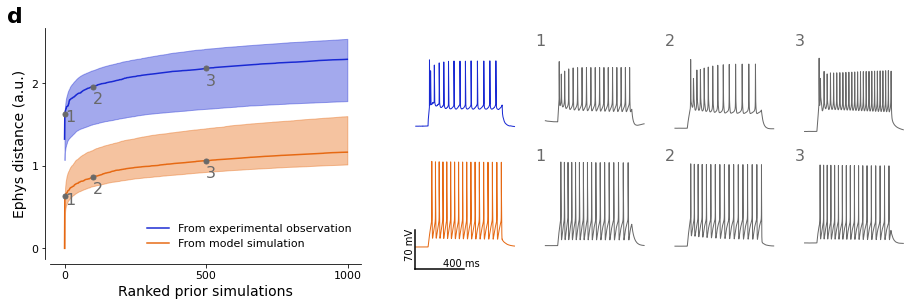

In [75]:
fig = plt.figure(figsize=(12, 4))
ax_mm_banana, axes_ex_1, axes_ex_2 = create_figure_1c(fig)

lw=1


# Model mismatch, banana
ax_mm_banana.plot(range(1000),E_distances, c='#1929d3ff', label='From experimental observation')
ax_mm_banana.plot(E_distances_ex, c='#e66913ff', label='From model simulation')
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_prior, 30, axis=0),
    np.percentile(E_distances_prior, 70, axis=0),
    color='#e66913ff',
    alpha=0.4
)
ax_mm_banana.fill_between(
    range(1000),
    np.percentile(E_distances_observations, 30, axis=0),
    np.percentile(E_distances_observations, 70, axis=0),
    color='#1929d3ff',
    alpha=0.4
)

ax_mm_banana.plot([1], [E_distances[1]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([100], [E_distances[100]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([500], [E_distances[500]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([1], [E_distances_ex[1]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([100], [E_distances_ex[100]],
                          color='dimgray', marker='.', markersize=10)
ax_mm_banana.plot([500], [E_distances_ex[500]],
                          color='dimgray', marker='.', markersize=10)

ax_mm_banana.annotate('1',(1, E_distances[1]-.1), color='dimgray', fontsize=16)
ax_mm_banana.annotate('2',(100, E_distances[100]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('3',(500, E_distances[500]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('1',(1, E_distances_ex[1]-.1), color='dimgray', fontsize=16)
ax_mm_banana.annotate('2',(100, E_distances_ex[100]-.2), color='dimgray', fontsize=16)
ax_mm_banana.annotate('3',(500, E_distances_ex[500]-.2), color='dimgray', fontsize=16)
ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=14)
ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=14)

ax_mm_banana.set_xticks([0,500,1000])
ax_mm_banana.set_yticks([0,1,2])
ax_mm_banana.tick_params(axis='both', which='major', labelsize=11)

ax_mm_banana.legend(loc='lower right', fontsize=11, frameon=False)

adjust_spines(ax_mm_banana, spines=['bottom', 'left'])

# Experimental observation and prior simulations close to it
axes_ex_1[0].plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
axes_ex_1[0].set_ylim([axes_ex_1[0].get_ylim()[0]-50, axes_ex_1[0].get_ylim()[1]+50])
axes_ex_1[0].set_xlim([axes_ex_1[0].get_xlim()[0]-50, axes_ex_1[0].get_xlim()[1]+50])
#axes_ex_1[0].set_title('Experimental observation', fontsize=16)
axes_ex_1[0].set_xticks([])
axes_ex_1[0].set_yticks([])
sns.despine(ax=axes_ex_1[0], bottom=True, left=True)


for i, ax in enumerate(axes_ex_1[1:]):
    ax.plot(x_prior['time'], x_prior['data'][i,0,:], lw=lw, color='dimgray')
    # ToDo NEED THIS ??
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)
    
    
# Prior simulation and prior simulations close to it  
axes_ex_2[0].plot(x_sim_ex['time'], x_sim_ex['data'][0,0,:], c='#e66913ff', lw=lw)
axes_ex_2[0].set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
axes_ex_2[0].set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
#axes_ex_2[0].set_title('Model simulation', fontsize=16)
axes_ex_2[0].set_xticks([])
axes_ex_2[0].set_yticks([])
sns.despine(ax=axes_ex_2[0], bottom=True, left=True)

for i, ax in enumerate(axes_ex_2[1:]):
    ax.plot(x_sim_prior['time'], x_sim_prior['data'][i,0,:], lw=lw, color='dimgray')
    ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
    ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
    ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
    ax.set_xticks([])
    ax.set_yticks([])
    sns.despine(ax=ax, bottom=True,left=True)


# axes_ex_2[0].plot([0,400], [-130,-130], 'k')
# axes_ex_2[0].annotate('400 ms', (220,-125))
# axes_ex_2[0].plot([0,0], [-130,-50], 'k')
# axes_ex_2[0].annotate('70 mV', (0,-75))

axes_ex_2[0].plot([-10,390], [-140,-140], 'k')
axes_ex_2[0].annotate('400 ms', (220,-135))
axes_ex_2[0].plot([-10,-10], [-140,-70], 'k')
axes_ex_2[0].annotate('70 mV', (-89,-120), rotation='90')

fig.text(-.05, .97, 'd', fontsize=22, fontweight='bold')

plt.savefig('../figures/figure_1c.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_1c.pdf', bbox_inches = 'tight', pad_inches = 0)

In [65]:
# fig = plt.figure(figsize=(12, 4))
# ax_mm_banana, axes_ex_1, axes_ex_2, axes_ex_3 = create_suppl_figure_1(fig)

# lw=1


# # Model mismatch, banana
# ax_mm_banana.plot(range(1000),E_distances, c='#1929d3ff', label='From experiment')
# ax_mm_banana.plot(range(1000),E_distances_without_rSS, c='magenta', label='From experiment using model without rSS')
# ax_mm_banana.plot(E_distances_ex, c='#e66913ff', label='From model simulation')
# ax_mm_banana.fill_between(
#     range(1000),
#     np.percentile(E_distances_prior, 30, axis=0),
#     np.percentile(E_distances_prior, 70, axis=0),
#     color='#e66913ff',
#     alpha=0.4
# )
# ax_mm_banana.fill_between(
#     range(1000),
#     np.percentile(E_distances_observations, 30, axis=0),
#     np.percentile(E_distances_observations, 70, axis=0),
#     color='#1929d3ff',
#     alpha=0.4
# )

# ax_mm_banana.fill_between(
#     range(1000),
#     np.percentile(E_distances_observations_without_rSS, 30, axis=0),
#     np.percentile(E_distances_observations_without_rSS, 70, axis=0),
#     color='magenta',
#     alpha=0.4
# )

# ax_mm_banana.plot([1], [E_distances[1]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([100], [E_distances[100]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([500], [E_distances[500]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([1], [E_distances_without_rSS[1]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([100], [E_distances_without_rSS[100]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([500], [E_distances_without_rSS[500]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([1], [E_distances_ex[1]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([100], [E_distances_ex[100]],
#                           color='dimgray', marker='.', markersize=10)
# ax_mm_banana.plot([500], [E_distances_ex[500]],
#                           color='dimgray', marker='.', markersize=10)


# ax_mm_banana.annotate('1',(1, E_distances[1]-.1), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('2',(100, E_distances[100]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('3',(500, E_distances[500]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('1',(1, E_distances_without_rSS[1]-.1), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('2',(100, E_distances_without_rSS[100]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('3',(500, E_distances_without_rSS[500]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('1',(1, E_distances_ex[1]-.1), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('2',(100, E_distances_ex[100]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.annotate('3',(500, E_distances_ex[500]-.2), color='dimgray', fontsize=16)
# ax_mm_banana.set_xlabel("Ranked prior simulations", fontsize=14)
# ax_mm_banana.set_ylabel("Ephys distance (a.u.)", fontsize=14)

# ax_mm_banana.set_xticks([0,500,1000])
# ax_mm_banana.set_yticks([-1,0,1,2,3,4])
# ax_mm_banana.tick_params(axis='both', which='major', labelsize=11)

# ax_mm_banana.legend(loc='lower right', fontsize=11, frameon=False)

# adjust_spines(ax_mm_banana, spines=['bottom', 'left'])

# # Experimental observation and prior simulations close to it, from model without rSS
# axes_ex_1[0].plot(observation['time'], observation['data'], c='magenta', lw=lw)
# axes_ex_1[0].set_ylim([axes_ex_1[0].get_ylim()[0]-50, axes_ex_1[0].get_ylim()[1]+50])
# axes_ex_1[0].set_xlim([axes_ex_1[0].get_xlim()[0]-50, axes_ex_1[0].get_xlim()[1]+50])
# #axes_ex_1[0].set_title('Experimental observation', fontsize=16)
# axes_ex_1[0].set_xticks([])
# axes_ex_1[0].set_yticks([])
# sns.despine(ax=axes_ex_1[0], bottom=True, left=True)


# for i, ax in enumerate(axes_ex_1[1:]):
#     ax.plot(x_prior_without_rSS['time'], x_prior_without_rSS['data'][i,0,:], lw=lw, color='dimgray')
#     # ToDo NEED THIS ??
#     ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
#     ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
#     ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     sns.despine(ax=ax, bottom=True,left=True)
    

# # Experimental observation and prior simulations close to it
# axes_ex_2[0].plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
# axes_ex_2[0].set_ylim([axes_ex_2[0].get_ylim()[0]-50, axes_ex_2[0].get_ylim()[1]+50])
# axes_ex_2[0].set_xlim([axes_ex_2[0].get_xlim()[0]-50, axes_ex_2[0].get_xlim()[1]+50])
# #axes_ex_1[0].set_title('Experimental observation', fontsize=16)
# axes_ex_2[0].set_xticks([])
# axes_ex_2[0].set_yticks([])
# sns.despine(ax=axes_ex_2[0], bottom=True, left=True)


# for i, ax in enumerate(axes_ex_2[1:]):
#     ax.plot(x_prior['time'], x_prior['data'][i,0,:], lw=lw, color='dimgray')
#     # ToDo NEED THIS ??
#     ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
#     ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
#     ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     sns.despine(ax=ax, bottom=True,left=True)
    
# # Prior simulation and prior simulations close to it  
# axes_ex_3[0].plot(x_sim_ex['time'], x_sim_ex['data'][0,0,:], c='#e66913ff', lw=lw)
# axes_ex_3[0].set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
# axes_ex_3[0].set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
# #axes_ex_2[0].set_title('Model simulation', fontsize=16)
# axes_ex_3[0].set_xticks([])
# axes_ex_3[0].set_yticks([])
# sns.despine(ax=axes_ex_3[0], bottom=True, left=True)

# for i, ax in enumerate(axes_ex_3[1:]):
#     ax.plot(x_sim_prior['time'], x_sim_prior['data'][i,0,:], lw=lw, color='dimgray')
#     ax.set_xlim([axes_ex_1[0].get_xlim()[0], axes_ex_1[0].get_xlim()[1]])
#     ax.set_ylim([axes_ex_1[0].get_ylim()[0], axes_ex_1[0].get_ylim()[1]])
#     ax.annotate(i+1,(ax.get_xlim()[0]+10,ax.get_ylim()[1]-30),fontsize=16,c='dimgray')
#     ax.set_xticks([])
#     ax.set_yticks([])
#     sns.despine(ax=ax, bottom=True,left=True)


# # axes_ex_2[0].plot([0,400], [-130,-130], 'k')
# # axes_ex_2[0].annotate('400 ms', (220,-125))
# # axes_ex_2[0].plot([0,0], [-130,-50], 'k')
# # axes_ex_2[0].annotate('70 mV', (0,-75))

# axes_ex_3[0].plot([-10,390], [-140,-140], 'k')
# axes_ex_3[0].annotate('400 ms', (220,-135))
# axes_ex_3[0].plot([-10,-10], [-140,-70], 'k')
# axes_ex_3[0].annotate('70 mV', (-89,-120), rotation='90')

# # fig.text(-.05, .97, 'b', fontsize=22, fontweight='bold')
# # fig.text(0.39, .97, 'c', fontsize=22, fontweight='bold')

# plt.savefig('figures/figure_1_suppl.png', bbox_inches = 'tight', pad_inches = 0)
# plt.savefig('figures/figure_1_suppl.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 1b

How we overcome model mismatch with neural posterior estimation.

In [81]:
with open('save_posteriors/training_schedule_0.pickle', 'rb') as f:
    npe_posterior=pickle.load(f)
with open('save_posteriors/training_schedule_2c.pickle', 'rb') as f:
    npep_posterior=pickle.load(f)

Fetch 3 posterior samples with highest posterior weight. Get there corresponding simulations and summary statistics.

In [82]:
from simulator import EphysModel
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=280,
                   save_chunks=True)

npe_samples=npe_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npe_samples=npe_samples[np.argsort(np.array(npe_posterior.log_prob(theta=npe_samples, x=xo[feature_list])))[-3:],:]
npep_samples=npep_posterior.sample(
    (10000,),
    x=torch.as_tensor(xo[feature_list], dtype=float),
)
npep_samples=npep_samples[np.argsort(np.array(npep_posterior.log_prob(theta=npep_samples, x=xo[feature_list])))[-3:],:]
x_npe=M1_model._run_HH_model(npe_samples.numpy())
x_npep=M1_model._run_HH_model(npep_samples.numpy())

summ_stats_npe=M1_model._simulation_wrapper(npe_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]
summ_stats_npep=M1_model._simulation_wrapper(npep_samples[-1,:].numpy()[np.newaxis,:]).numpy()[0,:]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [107]:
obs_index=np.where(Xo.index==cell_name)[0][0]

training_schedules=['0', '1', '2a', '2b', '2c', '2d', '2e', '3', '4']

best_prior_stats=np.load('./save_sims/best_1000_Euclidean_sims.npz')['stats'][::1000,:]
best_prior_stats_nans=np.isnan(best_prior_stats.sum(axis=1))

# highest_post_stats=np.load('./save_sims/highest_posterior_samples_summ_stats.npz')['stats']
# highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
# highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((len(training_schedules), Xo.shape[0]))

Xo_values=Xo.values[:,:-4]
# Xo_repeated=np.concatenate([Xo.values[:,:-4]]*len(training_schedules), axis=0)
Xo_mean=Xo.values[:,:-4].mean(axis=0)
Xo_std=Xo.values[:,:-4].std(axis=0)


prior_score=np.sqrt(
    (
        (best_prior_stats[obs_index,:]-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

npe_score=np.sqrt(
    (
        (summ_stats_npe-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

npep_score=np.sqrt(
    (
        (summ_stats_npep-Xo_mean)/Xo_std-\
        (Xo_values[obs_index,:]-Xo_mean)/Xo_std
    )**2
)

In [117]:
# obs_index=np.where(Xo.index==cell_name)[0][0]

# training_schedules=['0', '1', '2a', '2b', '2c', '2d', '2e', '3', '4']

# best_prior_stats=np.load('./save_sims/best_1000_Euclidean_sims.npz')['stats'][::1000,:]
# best_prior_stats_nans=np.isnan(best_prior_stats.sum(axis=1))

# highest_post_stats=np.load('./save_sims/highest_posterior_samples_summ_stats.npz')['stats']
# highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
# highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((len(training_schedules), Xo.shape[0]))

# Xo_values=Xo.values[:,:-4]
# Xo_repeated=np.concatenate([Xo.values[:,:-4]]*len(training_schedules), axis=0)
# Xo_mean=Xo.values[:,:-4].mean(axis=0)
# Xo_std=Xo.values[:,:-4].std(axis=0)


# prior_score=np.sqrt(
#     (
#         (best_prior_stats[obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

# sbi_score=np.sqrt(
#     (
#         (highest_post_stats[obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

# sbip_score=np.sqrt(
#     (
#         (highest_post_stats[Xo.shape[0]*4+obs_index,:]-Xo_mean)/Xo_std-\
#         (Xo_values[obs_index,:]-Xo_mean)/Xo_std
#     )**2
# )

In [113]:
mpl.rcParams.update({'font.size': 14})

In [114]:
def create_figure_1b(fig):
    
    if fig is None:
        fig=plt.figure(figsize=(15,7))
    else: fig = fig
    
    width, height= .07, .23
    ax_features=plt.axes([0,.52,.28,.45])
    ax_observation=plt.axes([0.2,-.05,width,height])
    axes_npe=np.array([[plt.axes([.31+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    axes_npep=np.array([[plt.axes([.66+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    
    return ax_features, ax_observation, axes_npe, axes_npep

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:



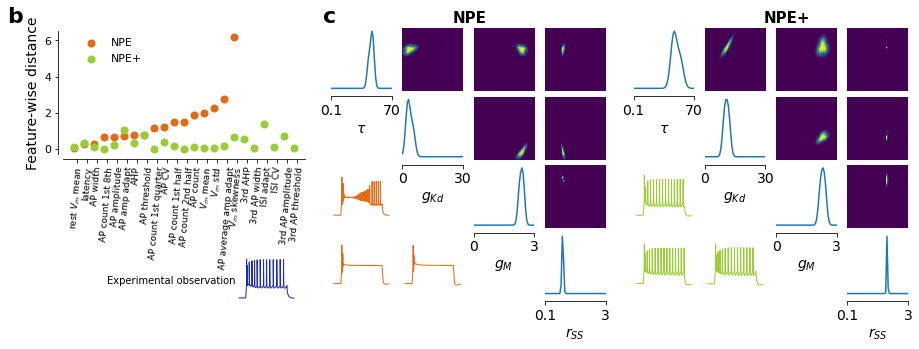

In [116]:
fig=plt.figure(figsize=(12,3.8))


dims_to_show=[2,5,6,12]
lw=1


ax_features, ax_observation, axes_npe, axes_npep = create_figure_1b(fig)

# Feature-wise performances NPE vs NPE+
order=np.argsort(npe_score)

ax_features.scatter(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        npe_score[order],
        color='#e66913ff',
        label='NPE',
        lw=2
       )
ax_features.scatter(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        npep_score[order],
        color='yellowgreen',
        label='NPE+',
        lw=2
       )

adjust_spines(ax_features, spines=['bottom', 'left'])


ax_features.set_xticks(np.linspace(1,4*len(ephys_features)+2, num=len(ephys_features)))
ax_features.legend(loc=(.05,.7), fontsize=11, frameon=False)
ax_features.set_ylabel('Feature-wise distance', fontsize=14)
ax_features.set_xticklabels(ephys_features[order], rotation=85)
ax_features.tick_params(axis='y', which='major', labelsize=11)
ax_features.tick_params(axis='x', which='major', labelsize=9)

# Experimental observation
ax_observation.plot(observation['time'], observation['data'], c='#1929d3ff', lw=lw)
ax_observation.set_ylim([ax_observation.get_ylim()[0]-30, ax_observation.get_ylim()[1]+30])
ax_observation.set_xticks([])
ax_observation.set_yticks([])
sns.despine(ax=ax_observation, bottom=True, left=True)

# SBI pairplot
pairplot(
    npe_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_npe,
    upper='kde',
    diag='kde'
)

axes_npe[3,0].plot(x_npe['time'],x_npe['data'][0,0,:],lw=lw,color='#e66913ff')
axes_npe[2,0].plot(x_npe['time'],x_npe['data'][1,0,:],lw=lw,color='#e66913ff')
axes_npe[3,1].plot(x_npe['time'],x_npe['data'][2,0,:],lw=lw,color='#e66913ff')

# SBI + noise pairplot
pairplot(
    npep_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_npep,
    upper='kde',
    diag='kde'
)
axes_npep[3,0].plot(x_npep['time'],x_npep['data'][0,0,:],lw=lw,color='yellowgreen')
axes_npep[2,0].plot(x_npep['time'],x_npep['data'][1,0,:],lw=lw,color='yellowgreen')
axes_npep[3,1].plot(x_npep['time'],x_npep['data'][2,0,:],lw=lw,color='yellowgreen')

for ax in [axes_npe[3,0],axes_npe[2,0],axes_npe[3,1],axes_npep[3,0],axes_npep[2,0],axes_npep[3,1]]:
    ax.set_ylim([ax_observation.get_ylim()[0], ax_observation.get_ylim()[1]])

fig.text(-0.065, 1, 'b', fontsize=22, fontweight='bold')
fig.text(.3, 1, 'c', fontsize=22, fontweight='bold')
# fig.text(.65, 1, 'd', fontsize=22, fontweight='bold')

fig.text(.45, 1, 'NPE', fontsize=15, fontweight='bold', color='k')
fig.text(.81, 1, 'NPE+', fontsize=15, fontweight='bold', color='k')

fig.text(.05,.045,'Experimental observation', fontsize=10, color='k')

plt.savefig('../figures/figure_1b.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_1b.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 2

t-SNE overlayed with fitted model parameters, fitted electrophysiology, true electrophysiology and marker genes

In [118]:
with open('save_posteriors/training_schedule_0.pickle', 'rb') as f:
    npe_posterior=pickle.load(f)
with open('save_posteriors/training_schedule_2c.pickle', 'rb') as f:
    npep_posterior=pickle.load(f)

Let us get the gene expression levels for the same cells.

In [137]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
# IonChannelGenes = pd.read_csv('../data/GO_term_summary_20211104_075621.txt', header = 0, sep = '\t')
# selectedGenes = np.array([(gene in IonChannelGenes['MGI Gene/Marker ID'].values) | (gene in ['Pvalb', 'Lamp5', 'Vip', 'Sst', ])  for gene in data_exons.index])
# enough_counts = np.sum(data_exons, axis = 1) >= 10
# data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names#[selectedGenes & enough_counts]

Select 1000 most variable genes.

In [142]:
from rnaseqTools import geneSelection

Chosen offset: 7.53


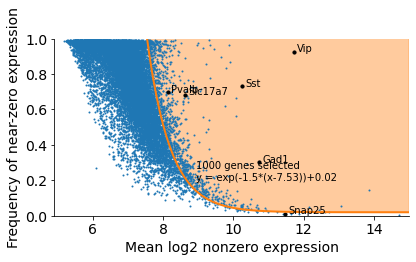

In [144]:
amount_of_genes = 1000
markerGenes = ['Snap25', 'Gad1', 'Slc17a7', 'Pvalb', 'Sst', 'Vip']
selectedGenes = geneSelection(exonCounts, n=amount_of_genes, threshold=30, markers=markerGenes, genes=gene_names)
exonCounts=exonCounts[:,selectedGenes]
gene_names=gene_names[selectedGenes]

In [149]:
exonCounts.shape

(955, 1000)

In [150]:
gene_names.shape

(1000,)

Further preprocessing for genes (library size normalization and Z-scoring).

In [151]:
genes = exonCounts.copy()
genes = genes / np.sum(genes, axis=1, keepdims=True) * np.median(np.sum(genes, axis=1, keepdims=True))
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype('float64')

In [ ]:
# ind=training_flows_specifics['ind']
# G=training_flows_specifics['G']
# THETA=training_flows_specifics['THETA']
# G_train_mean=training_flows_specifics['G_train_mean']
# THETA_train_mean=training_flows_specifics['THETA_train_mean']
# THETA_mean=training_flows_specifics['THETA_mean']
# THETA_std=training_flows_specifics['THETA_std']
# colors=training_flows_specifics['colors']
# gene_names=training_flows_specifics['gene_names']

In [152]:
tsne = TSNE(
    perplexity=30,
    metric="euclidean",
    n_jobs=8,
    random_state=42,
    verbose=True,
)

In [157]:
Z = tsne.fit(G)

--------------------------------------------------------------------------------
TSNE(n_jobs=8, random_state=42, verbose=True)
--------------------------------------------------------------------------------
===> Finding 90 nearest neighbors using exact search using euclidean distance...
   --> Time elapsed: 0.25 seconds
===> Calculating affinity matrix...
   --> Time elapsed: 0.03 seconds
===> Calculating PCA-based initialization...
   --> Time elapsed: 0.19 seconds
===> Running optimization with exaggeration=12.00, lr=200.00 for 250 iterations...
Iteration   50, KL divergence 2.8282, 50 iterations in 0.1791 sec
Iteration  100, KL divergence 2.7620, 50 iterations in 0.1148 sec
Iteration  150, KL divergence 2.7680, 50 iterations in 0.1005 sec
Iteration  200, KL divergence 2.7121, 50 iterations in 0.0951 sec
Iteration  250, KL divergence 2.7661, 50 iterations in 0.0961 sec
   --> Time elapsed: 0.59 seconds
===> Running optimization with exaggeration=1.00, lr=200.00 for 500 iterations...

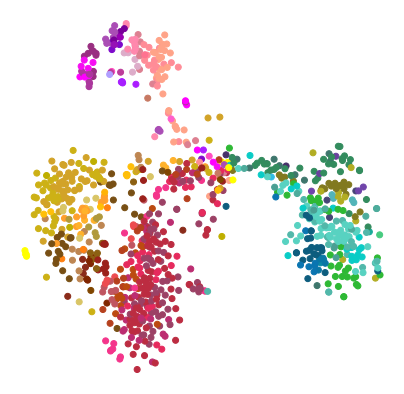

In [190]:
plt.figure(figsize=(7,7))
plt.scatter(Z[:,0],Z[:,1],c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

In [160]:
#Z_genes = tsne.fit(G.numpy())
#Z_theta = tsne.fit(THETA.numpy())
#Z_ephys = tsne.fit((Xo.iloc[ind,:].values[:,:-4]-Xo.values.mean(axis=0)[:-4])/Xo.values.std(axis=0)[:-4])

In [83]:
# fig, axes = plt.subplots(1,3,figsize=(15,5))
# axes[0].scatter(Z_genes[:,0],Z_genes[:,1],c=colors,s=7)
# axes[1].scatter(Z_ephys[:,0],Z_ephys[:,1],c=colors,s=7)
# axes[2].scatter(Z_theta[:,0],Z_theta[:,1],c=colors,s=7)
# axes[0].set_title('genes', fontsize=15)
# axes[1].set_title('ephys', fontsize=15)
# axes[2].set_title('model parameters', fontsize=15)
# for ax in axes:
#     sns.despine(ax=ax,left=True,bottom=True)
#     ax.set_xticks([])
#     ax.set_yticks([])
# plt.savefig('figures/preliminary/tsnes.png',dpi=200)

In [161]:
with open('save_model_parameters/across_training_schedules.pickle', 'rb') as f:
        THETAS = pickle.load(f)

fav_tr_schedule='2c'

highest_posterior_samples=np.array(
    [THETAS[fav_tr_schedule]['highest posterior samples'][cell] for cell in Xo.index]
)

In [163]:
with open('save_model_parameters/favourite_training_schedule.pickle', 'rb') as f:
    fav_training_schedule=pickle.load(f)
samples=np.concatenate(
    [fav_training_schedule['samples'][cell] for cell in Xo.index]
).reshape((Xo.shape[0],1000,len(model_param_names)))
samples=torch.as_tensor(samples,dtype=torch.float32)
#samples=samples[ind,:,:]
# samples=(samples-THETA_mean)/THETA_std

In [164]:
# sbip_samples=sbip_posterior.sample(
#     (10000,),
#     x=torch.as_tensor(xo[feature_list], dtype=float),
# )
# sbip_samples_to_show=sbip_samples[np.argsort(np.array(sbip_posterior.log_prob(theta=sbip_samples, x=xo[feature_list])))[-3:],:]
# x_sbip=M1_model._run_HH_model(sbip_samples_to_show.numpy())

The following result should be pretty high in comparison to next block's values

In [162]:
npep_posterior.log_prob(highest_posterior_samples[0,:], x=Xo.iloc[0,:].values[feature_list])

tensor([-27.5465])

In [165]:
npep_posterior.log_prob(samples[0,:,:],x=Xo.iloc[0,:].values[feature_list])[:10]

tensor([-43.1412, -34.1297, -29.4719, -33.9141, -32.1316, -29.7763, -32.9100,
        -37.2205, -37.3973, -30.6168])

You can run it once and then simply load next block any other time

In [167]:
uncertainty=np.zeros((Xo.shape[0]))
for i in range(Xo.shape[0]):
    if i%100==0:
        print(i, end='')
    print('.', end='')
    uncertainty[i]=torch.mean(-npep_posterior.log_prob(samples[i,:,:],x=Xo.iloc[i,:].values[feature_list])).item()
np.savez('./save_uncertainty/npep_entropy.npz',
     entropy=uncertainty
        )

In [89]:
uncertainty=np.load('./save_uncertainty/npep_entropy.npz')['entropy']

Also here, run it once, just load the next time.

In [169]:
from simulator import EphysModel
M1_model=EphysModel(name='M1',
                   T=25.0,
                   E_Na=69.0,
                   E_K=-98.4,
                   E_Ca=127.2,
                   start=100,
                   end=700,
                   dt=0.04,
                   n_processes=40,
                   noise_factor=10,
                   use_pathos=True,
                   chunk_size=280,
                   save_chunks=True)
M1_model.sim(torch.as_tensor(highest_posterior_samples, dtype=torch.float32))
np.savez('./save_sims/training_schedule_{}_MAP_stats.npz'.format(fav_tr_schedule),
     stats=M1_model.stats.numpy()
    )

Chunks:
....
Training set of parameters and summary statistics has been made:
parameters shape:  torch.Size([955, 13])
summary statistics shape:  torch.Size([955, 23])


In [171]:
MAP_stats=np.load('./save_sims/training_schedule_{}_MAP_stats.npz'.format(fav_tr_schedule))['stats']
MAP_stats=MAP_stats

In [172]:
def create_figure_2(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(14, 10))
    else: fig = fig
    
    width, height=.14, .12
    w_scale, h_scale=width*1.2, height*1.2
    ax_latent=plt.axes([0,.6,(w_scale-.02)*2,h_scale*2])
    axes_marker_genes=np.array(
        [[plt.axes([x,y,width,height]) for x in [.167*2, .167*3]] for y in [.6+h_scale,.6]]
    )
    ax_HH_uncertainty=plt.axes([w_scale*4,.6,w_scale*2,h_scale*2])
    axes_params=np.array([plt.axes([x,.4,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    axes_fitted_ephys=np.array([plt.axes([x,.2,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    axes_true_ephys=np.array([plt.axes([x,0,width,height]) for x in [0,w_scale,w_scale*2,w_scale*3,w_scale*4,w_scale*5]])
    
    return ax_latent, axes_marker_genes, ax_HH_uncertainty, axes_params, axes_fitted_ephys, axes_true_ephys

In [173]:
def latent_space_overlays(Z, X, X_column_index, geneNames, alpha = 1, triangle_max_len=50,
                       fontsize=14, axis = None):
    '''
    Parameters
    ----------
    Z: latent space coordinates (2D numpy array)
    X: normalized overlaying data (2D numpy array)
    X_column_index: column index in X, correspoding to certain feature
    names: list of feature names (X_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    triangle_max_len: # triangles with too long edges (poorly constrained by data) (default=50)
    fontsize: fontsize of title (default: 13)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure objects; latent space with gene activation contours
    '''
    
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))    
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation(Z[:,0], Z[:,1])
    
    # extract coordinates of each triangle
    x1=Z[:,0][triang.triangles][:,0]
    x2=Z[:,0][triang.triangles][:,1]
    x3=Z[:,0][triang.triangles][:,2]
    y1=Z[:,1][triang.triangles][:,0]
    y2=Z[:,1][triang.triangles][:,1]
    y3=Z[:,1][triang.triangles][:,2]
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 50th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(
        np.max(edges, axis=1)>np.max(edges, axis=1)[
            np.argsort(np.max(edges, axis=1))
        ][-triangle_max_len]
    )
    ax.tricontourf(triang, X[:, X_column_index], cmap='inferno',
                   levels=np.linspace(-2,2,5), extend='both')
    ax.set_xlim([np.min(Z[:, 0]), np.max(Z[:, 0])])
    ax.set_ylim([np.min(Z[:, 1]), np.max(Z[:, 1])])
    ax.set_title(geneNames[X_column_index], fontsize=fontsize, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

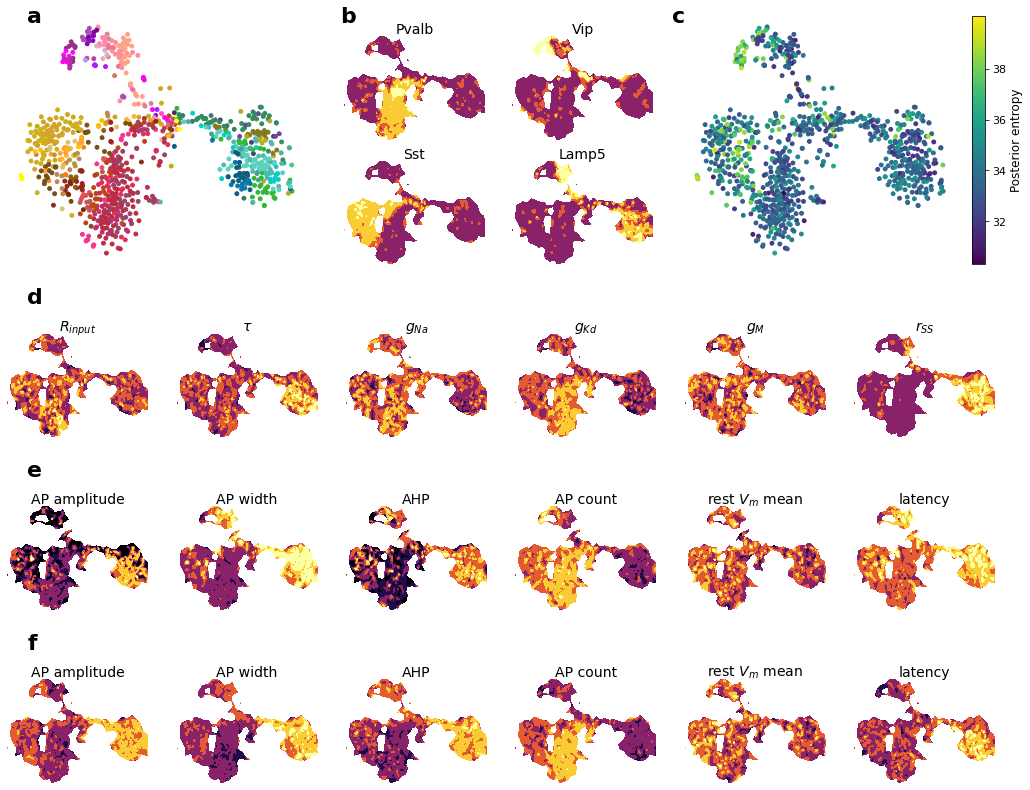

In [182]:
fig = plt.figure(figsize=(14, 12))
ax_latent, axes_marker_genes, ax_HH_uncertainty, axes_params, axes_fitted_ephys, axes_true_ephys = create_figure_2(fig)

# t-SNE latent
ax_latent.scatter(Z[:,0], Z[:,1], s=15, c=colors)
ax_latent.set_xticks([])
ax_latent.set_yticks([])
sns.despine(ax=ax_latent, left=True, bottom=True)

# uncertainty of fitted model parameters
scatter=ax_HH_uncertainty.scatter(Z[:,0], Z[:,1], s=15, c=uncertainty, cmap='viridis')
cbar=plt.colorbar(scatter, ax=ax_HH_uncertainty, ticks=[32,34,36,38])#, anchor=(,.5))
cbar.ax.tick_params(labelsize=11)
cbar.set_label('Posterior entropy', fontsize=12)
ax_HH_uncertainty.set_xticks([])
ax_HH_uncertainty.set_yticks([])
sns.despine(ax=ax_HH_uncertainty, left=True, bottom=True)

# marker genes
marker_gene_ids=[
    np.where(gene_names=='Pvalb')[0][0],
    np.where(gene_names=='Vip')[0][0],
    np.where(gene_names=='Sst')[0][0],
    np.where(gene_names=='Lamp5')[0][0]
]
for i, ax in enumerate(axes_marker_genes.reshape(-1)):
    latent_space_overlays(Z, G, 
        marker_gene_ids[i], gene_names, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)

# model params
model_param_ids_to_show=[1,2,4,5,6,-1] 
for i, ax in enumerate(axes_params):
    latent_space_overlays(Z, (highest_posterior_samples-highest_posterior_samples.mean(axis=0))/highest_posterior_samples.std(axis=0), 
        model_param_ids_to_show[i], model_param_names, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)
    
ephys_feature_ids_to_show=[1,2,3,8,19,18]
for i, ax in enumerate(axes_fitted_ephys.reshape(-1)):
    latent_space_overlays(
        Z[~np.isnan(MAP_stats.mean(axis=1)),:],
        (MAP_stats[~np.isnan(MAP_stats.mean(axis=1)),:]-Xo.values.mean(axis=0)[:-4])/Xo.values.std(axis=0)[:-4], 
        ephys_feature_ids_to_show[i], ephys_features, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)
    
for i, ax in enumerate(axes_true_ephys.reshape(-1)):
    latent_space_overlays(Z, (Xo.values[:,:-4]-Xo.values.mean(axis=0)[:-4])/Xo.values.std(axis=0)[:-4], 
        ephys_feature_ids_to_show[i], ephys_features, triangle_max_len=150, axis=ax)
    sns.despine(ax=ax, bottom=True, left=True)

shift=.02
fig.text(0+shift, .88, 'a', fontsize=22, fontweight='bold')
#fig.text(.11, .91, 'Latent', fontsize=19)
fig.text(.33, .88, 'b', fontsize=22, fontweight='bold')
#fig.text(.43, .91, 'Marker genes', fontsize=19)
fig.text(.66, .88, 'c', fontsize=22, fontweight='bold')
#fig.text(.73, .91, 'Fit uncertainty', fontsize=19)
fig.text(0+shift, .555, 'd', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .555, 'Model parameters', fontsize=19)
fig.text(0+shift, .355, 'e', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .355, 'Model electrophysiology', fontsize=19)
fig.text(0+shift, .155, 'f', fontsize=22, fontweight='bold')
#fig.text(.03+shift, .155, 'Experimental electrophysiology', fontsize=19)

plt.savefig('../figures/figure_2.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('../figures/figure_2.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 3

This analysis with figure can be found in **ToDo**.  

### Figure 4

We use sparse reduced-rank regression to predict model parameters from gene expression levels.

In [192]:
# Allen data t-type ordering:
allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))
clusterNames = allen['neurons']['clusterNames']

WARNING    /tmp/ipykernel_39437/668696660.py:2: DeprecationWarning: Please use `csc_matrix` from the `scipy.sparse` namespace, the `scipy.sparse.csc` namespace is deprecated.
  allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))
 [py.warnings]
  allen = pickle.load(open('../data/SmartSeq_cells_AIBS.pickle', 'rb'))



In [193]:
clusterNames[np.where(clusterNames=='L5 PT_1')[0]]='L5 ET_1'
clusterNames[np.where(clusterNames=='L5 PT_2')[0]]='L5 ET_2'
clusterNames[np.where(clusterNames=='L5 PT_3')[0]]='L5 ET_3'
clusterNames[np.where(clusterNames=='L5 PT_4')[0]]='L5 ET_4'

In [194]:
ttypes=[]
for ttype in clusterNames:
    if ttype in celltypes.values:
        ttypes.append(ttype)
ttypes=np.array(ttypes)

In [195]:
with open('save_model_parameters/across_training_schedules.pickle', 'rb') as f:
        THETAS = pickle.load(f)

fav_tr_schedule='2c'

highest_posterior_samples=np.array(
    [THETAS[fav_tr_schedule]['highest posterior samples'][cell] for cell in Xo.index]
)

In [197]:
highest_posterior_samples_standardized=(highest_posterior_samples-highest_posterior_samples.mean(axis=0))/highest_posterior_samples.std(axis=0)
family_av_model_params=np.array([highest_posterior_samples_standardized[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
df_family=pd.DataFrame(data=family_av_model_params.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.703295,-0.144394,-0.137199,-0.261514,-0.448807,0.514726
$R_{input}$,-0.486859,-0.018637,0.169277,0.059983,0.216389,-0.163523
$\tau$,-0.633448,-0.469063,-0.770364,-0.207068,-0.140527,0.682171
$g_{Nat}$,-0.773110,-0.880396,-0.168501,-0.198060,-0.059198,0.530910
$g_{Na}$,0.085663,0.241598,0.374895,-0.102727,0.323861,-0.355944
$g_{Kd}$,-0.315074,0.198385,-0.589937,-0.032513,0.859027,-0.664133
$g_{M}$,-0.061823,0.339380,-0.258818,0.005776,0.113161,-0.067325
$g_{Kv31}$,-0.669325,-0.943894,-0.404554,-0.075706,1.072147,-0.733450
$g_{L}$,0.258870,-0.122349,-0.443246,-0.217239,-0.337992,0.552562
$E_{leak}$,-0.033061,0.314734,-0.131391,0.374053,-0.104289,-0.191549


Briefly, to see average real parameter values across families.

In [198]:
#highest_posterior_samples_standardized=(highest_posterior_samples-THETA_mean)/THETA_std
real_family_av_model_params=np.array([highest_posterior_samples[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
real_df_family=pd.DataFrame(data=real_family_av_model_params.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
real_df_family

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,12.511106,10.257022,10.276152,9.945586,9.447557,12.009685
$R_{input}$,292.480011,365.540161,394.861725,377.807831,402.212982,342.932465
$\tau$,14.101623,16.321526,12.252680,19.859568,20.758158,31.868063
$g_{Nat}$,50.154766,43.331837,88.605415,86.725571,95.556664,133.084976
$g_{Na}$,54.957214,58.440807,61.418667,50.748539,60.278595,45.091602
$g_{Kd}$,14.288827,17.454840,12.594007,16.031103,21.528395,12.136516
$g_{M}$,1.830194,2.076968,1.709025,1.871773,1.937824,1.826810
$g_{Kv31}$,39.192303,24.287470,53.565216,71.416512,133.727036,35.711334
$g_{L}$,1.072952,0.877366,0.712728,0.828682,0.766729,1.223632
$E_{leak}$,-80.186455,-77.365906,-80.983887,-76.884834,-80.764076,-81.471748


In [199]:
family_av_model_params=np.array([highest_posterior_samples_standardized[celltypes.values==ttype,:].mean(axis=0) for ttype in ttypes])
df_type=pd.DataFrame(data=family_av_model_params.T, index=model_param_names, columns=ttypes)
df_type

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.412388,0.726676,0.873687,1.617476,0.748623,0.682677,-0.087853,0.264158,-0.367587,-0.452624,...,-0.303667,1.535266,0.467368,0.507689,0.430706,1.106767,0.995747,1.482103,0.324548,-0.037313
$R_{input}$,-0.742856,-0.418945,-0.398619,-0.020030,-0.499839,-0.529398,0.013178,0.398337,-0.282846,-0.360712,...,-0.020632,-0.623936,0.040545,-0.490246,-0.385507,-0.066396,-0.566547,-0.682262,-0.430732,-0.893102
$\tau$,-0.910894,-0.844748,-0.660028,0.007904,-0.627137,-0.563271,-0.362333,-0.049981,-0.772121,-0.694405,...,0.620876,-0.712071,-0.200710,-0.572464,-0.026434,-0.022404,-0.694314,-0.214334,-0.846258,-1.098434
$g_{Nat}$,-1.306077,-0.734689,-0.689994,-1.123316,-0.578859,-0.820636,-0.984083,-0.983182,-1.085457,-1.070977,...,0.846347,0.448881,-0.245199,-0.112122,0.282867,-0.517612,-0.304334,1.624275,-0.980155,0.442579
$g_{Na}$,-0.515087,-0.097074,0.144710,0.954228,-0.069387,0.215417,1.051513,-0.034233,1.179096,-0.277425,...,-0.580777,0.961002,-0.131066,-0.434482,-0.074971,-0.068091,0.625289,-0.167758,0.081305,-0.247156
$g_{Kd}$,0.309693,-0.066718,-0.513532,0.779991,-0.578359,-0.258355,-1.033746,0.657886,-0.631122,1.000445,...,-1.154707,1.079656,-0.388150,-0.395065,-0.764732,-0.251342,-0.554742,-0.118711,-0.463181,-0.315693
$g_{M}$,1.217926,-0.005917,-0.285406,-0.361881,-0.495772,0.032120,0.422706,0.950608,0.187747,1.035304,...,0.688972,-0.307828,0.182742,0.827382,0.188529,-0.434663,-0.008871,-0.405033,-0.063518,0.790316
$g_{Kv31}$,-0.537295,-0.719607,-0.810164,-1.144200,-0.627417,-0.633384,-0.854401,-1.070603,-1.003446,-0.772280,...,-0.493802,-1.043734,-0.926751,-1.046879,-0.612111,-1.061102,-1.235976,-0.954050,-0.914762,-0.962499
$g_{L}$,0.482633,-0.102795,-0.185097,0.037041,-0.047252,0.648672,0.078215,0.116392,-0.697930,-0.244811,...,1.645858,1.053058,-0.477944,-0.422898,-0.048510,-0.472185,-0.633560,-0.146667,0.496244,-0.250227
$E_{leak}$,0.283873,0.076099,0.606082,0.393981,0.220233,-0.468564,0.307906,-0.118340,1.004942,0.104653,...,0.481927,-0.533219,-0.189336,0.139088,-0.242048,-0.833041,-0.002081,-1.024757,-0.290113,-0.092936


In [200]:
import sparseRRR

In [202]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T

Some numbers for in the manuscript:

In [203]:
data_exons.shape

(42466, 955)

In [204]:
np.min(np.sum(data_exons.T.values!=0,axis=1))

1202

In [205]:
np.max(np.sum(data_exons.T.values!=0,axis=1))

18118

In [206]:
np.mean(np.sum(data_exons.T.values!=0,axis=1))

7244.528795811519

We load the gene expression levels again but this time keep the ion channel and marker genes. 

In [207]:
data_exons = pd.read_csv('../data/m1_patchseq_exon_counts.csv.gz', na_filter=False, index_col=0)
data_exons = data_exons.T.reindex(Xo.index).T
original_gene_names = np.array(data_exons.index)
IonChannelGenes = pd.read_csv('../data/GO_term_summary_20211104_075621.txt', header = 0, sep = '\t')
selectedGenes = np.array([(gene in IonChannelGenes['MGI Gene/Marker ID'].values) | (gene in ['Pvalb', 'Lamp5', 'Vip', 'Sst', ])  for gene in data_exons.index])
enough_counts = np.sum(data_exons, axis = 1) >= 10
data_exons = data_exons.loc[selectedGenes & enough_counts, :]
exonCounts = data_exons.values.transpose()
gene_names = original_gene_names[selectedGenes & enough_counts]

Further preprocessing for genes (gene selection, library size normalization and Z-scoring)

In [208]:
genes = exonCounts.copy()
genes = genes / np.sum(genes, axis=1, keepdims=True) * np.median(np.sum(genes, axis=1, keepdims=True))
genes = np.log2(genes + 1)
genes = genes - np.mean(genes, axis=0)
genes = genes / np.std(genes, axis=0)
G = genes.astype('float64')

In [218]:
w,v = sparseRRR.relaxed_elastic_rrr(G, highest_posterior_samples_standardized.astype(np.float64), rank=2, lambdau=0.163, alpha=1)
print('Genes selected: {}'.format(np.sum(w[:,0]!=0)))

Genes selected: 25


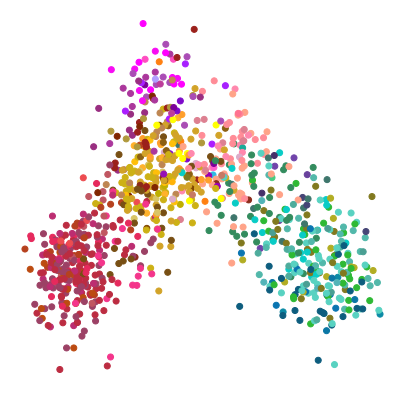

In [224]:
plt.figure(figsize=(7,7))
plt.scatter((G@w)[:,0],(G@w)[:,1], c=colors)
plt.xticks([])
plt.yticks([])
sns.despine(left=True, bottom=True)

In [225]:
gene_names[w[:,0]!=0]

array(['Ano10', 'Cacna2d1', 'Cacna2d2', 'Cacng3', 'Gabra5', 'Gabrd',
       'Grik1', 'Kcnab3', 'Kcnc1', 'Kcnc3', 'Kcnc4', 'Kcnip2', 'Kcnip3',
       'Kcnv1', 'Lamp5', 'P2rx4', 'Pex5l', 'Pvalb', 'Ryr1', 'Scn1a',
       'Scn3b', 'Slc17a7', 'Slc24a4', 'Tpcn2', 'Vip'], dtype=object)

In [222]:
ttype_av_model_params_sRRR=np.array([(G@w@v.T)[celltypes.values==ttype,:].mean(axis=0) for ttype in ttypes])
df_ttype_sRRR=pd.DataFrame(data=ttype_av_model_params_sRRR.T, index=model_param_names, columns=ttypes)
df_ttype_sRRR

,Lamp5 Pax6,Lamp5 Egln3_1,Lamp5 Egln3_2,Lamp5 Pdlim5_1,Lamp5 Pdlim5_2,Lamp5 Slc35d3,Lamp5 Lhx6,Sncg Col14a1,Sncg Calb1_1,Sncg Calb1_2,...,L5 ET_4,L5/6 NP CT,L6 CT Cpa6,L6 CT Grp,L6 CT Pou3f2,L6b Col6a1,L6b Shisa6_1,L6b Shisa6_2,L6b Ror1,L5/6 NP_1
C,0.100495,0.232102,0.223183,0.355708,0.295968,0.279757,0.138966,0.076820,-0.019384,0.169682,...,0.433270,0.335686,0.343945,0.176521,0.395290,0.498133,0.415874,0.620967,0.432791,0.429048
$R_{input}$,-0.055017,-0.115674,-0.110435,-0.177547,-0.145099,-0.129570,-0.067233,-0.053968,-0.004244,-0.081387,...,-0.169962,-0.160494,-0.149772,-0.085792,-0.173984,-0.217670,-0.188244,-0.266784,-0.191408,-0.193053
$\tau$,-0.208394,-0.206880,-0.179789,-0.323565,-0.205872,-0.011956,-0.075093,-0.446267,-0.317683,-0.074674,...,0.721211,-0.135295,0.214796,-0.104781,0.202207,0.292863,0.087461,0.474952,0.199282,0.118036
$g_{Nat}$,-0.182286,-0.193432,-0.170126,-0.301843,-0.198614,-0.036276,-0.075368,-0.377318,-0.261620,-0.077915,...,0.557256,-0.143829,0.145715,-0.103526,0.130437,0.195925,0.033341,0.335352,0.124478,0.057455
$g_{Na}$,0.019592,-0.031567,-0.035712,-0.046556,-0.056470,-0.104501,-0.032552,0.095305,0.096398,-0.044511,...,-0.368910,-0.091537,-0.192719,-0.038720,-0.208988,-0.274012,-0.184804,-0.372335,-0.222627,-0.198441
$g_{Kd}$,-0.210926,-0.418279,-0.397403,-0.642668,-0.518834,-0.444579,-0.238196,-0.233255,-0.049132,-0.286574,...,-0.502887,-0.563814,-0.488989,-0.304924,-0.573193,-0.712772,-0.634482,-0.860959,-0.633120,-0.647602
$g_{M}$,-0.108229,-0.168250,-0.156086,-0.259791,-0.197296,-0.132106,-0.086214,-0.168181,-0.085688,-0.100203,...,0.015669,-0.194531,-0.094081,-0.112310,-0.121422,-0.141683,-0.165047,-0.143904,-0.139524,-0.161996
$g_{Kv31}$,-0.316398,-0.584362,-0.551697,-0.899038,-0.714253,-0.577705,-0.323858,-0.394939,-0.129876,-0.386363,...,-0.500116,-0.757718,-0.587835,-0.416390,-0.699408,-0.861076,-0.802655,-1.014800,-0.777553,-0.813248
$g_{L}$,-0.087504,-0.037073,-0.024138,-0.060732,-0.012435,0.098076,0.007132,-0.239458,-0.198333,0.018942,...,0.596731,0.044951,0.258587,0.003410,0.270336,0.363550,0.209079,0.519269,0.282688,0.232422
$E_{leak}$,0.080153,0.094095,0.084130,0.146365,0.100770,0.034669,0.040160,0.156457,0.103248,0.043392,...,-0.191674,0.081719,-0.033500,0.054129,-0.023689,-0.042472,0.016631,-0.089390,-0.018603,0.007935


In [223]:
family_av_model_params_sRRR=np.array([(G@w@v.T)[family,:].mean(axis=0) for family in [celltype_Lamp5, celltype_Sncg, celltype_Vip, celltype_Sst, celltype_Pvalb, celltype_Pyr]])
df_family_sRRR=pd.DataFrame(data=family_av_model_params_sRRR.T, index=model_param_names, columns=['Lamp5', 'Sncg', 'Vip', 'Sst', 'Pvalb', 'Pyr'])
df_family_sRRR

,Lamp5,Sncg,Vip,Sst,Pvalb,Pyr
C,0.257829,0.078861,0.022822,-0.057103,-0.500373,0.484938
$R_{input}$,-0.123917,-0.051887,-0.039892,0.013903,0.225403,-0.199526
$\tau$,-0.119498,-0.373436,-0.707333,-0.299738,-0.131473,0.583291
$g_{Nat}$,-0.123392,-0.317113,-0.588724,-0.243184,-0.061877,0.438013
$g_{Na}$,-0.065945,0.074131,0.189198,0.105916,0.229699,-0.350221
$g_{Kd}$,-0.436957,-0.218199,-0.213542,0.014908,0.756812,-0.619056
$g_{M}$,-0.154052,-0.147433,-0.221106,-0.063014,0.190768,-0.049140
$g_{Kv31}$,-0.590290,-0.360257,-0.423924,-0.043274,0.951742,-0.679205
$g_{L}$,0.025155,-0.194893,-0.416769,-0.201734,-0.267341,0.533234
$E_{leak}$,0.067934,0.132523,0.237126,0.093156,-0.011306,-0.140255


In [230]:
# def create_figure_4(fig):
    
#     if fig is None:
#         fig = plt.figure(figsize=(12,12))
#     else: fig = fig
    
#     width, height= .07, .07
#     ax_tr_curves=plt.axes([0.05,0.77,.38,.21])
#     ax_observation=plt.axes([0.4,0.64,width,height])
#     axes_nf=np.array([[plt.axes([.5+x,y,width,height]) for x in [0,.1,.2,.3]] for y in [.94,.85,.76,.67]])
    
    
    
#     ax_df_sbip_fam=plt.axes([0,.42,.08,.17])
#     ax_df_sbip_ttype=plt.axes([.1,.42,.9,.17])
#     ax_df_average_fam=plt.axes([0,0.21,.08,.17])
#     ax_df_average_ttype=plt.axes([.1,0.21,.9,.17])
#     ax_df_specific_fam=plt.axes([0,0,.08,.17])
#     ax_df_specific_ttype=plt.axes([.1,0,.9,.17])
    
#     return ax_tr_curves, ax_observation, axes_nf, ax_df_sbip_fam, ax_df_sbip_ttype, ax_df_average_fam, ax_df_average_ttype, ax_df_specific_fam, ax_df_specific_ttype

In [227]:
def latent_space_genes_sRRR(X, vx, index, geneNames, alpha = 0.5, axis = None):
    ''' 
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    index: index in the 25 genes selected for the gene that you'd like to show
    geneNames: list of gene names (X_column_index should correspond to correct gene in this list!)
    alpha: transparancy for contours (default = 0.5)
    ax: axis to plot one (default: None)
    
    Returns
    -------
    axis: figure objects; latent space with gene activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, X@vx@np.linalg.pinv(vx)[:, np.sum(vx, axis = 1)!=0][:, index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(geneNames[np.sum(vx, axis = 1)!=0][index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [228]:
def latent_space_ephys_sRRR(X, vx, vy, Y_column_index, features, alpha = 1, axis = None):

    '''
    Parameters
    ----------
    model: keras deep bottleneck neural network regression model
    X: 2D numpy array, normalized transcriptomic data
    vx: matrix to (linearly) project to botteneck
    vy: matrix to (linearly) project from bottleneck to ephys space
    Y_column_index: column index in Y, correspoding to certain feature
    features: list of all ephys features (Y_column_index should correspond to correct feature in this list!)
    alpha: transparancy for contours (default = 0.5)
    axis: axis to plot one (default: None)
    
    Returns
    -------
    ax: figure object, latent space with ephys activation contours
    '''
    # Create figure
    if axis:
        ax = axis
    else:
        fig, ax = plt.subplots(nrows=1,ncols=1, figsize = (6, 6))
    
    # produces triangles from latent coordinates
    triang = tri.Triangulation((X@vx)[:,1], (X@vx)[:,0])
    
    # extract coordinates of eacht triangle
    x1=(X@vx)[:,1][triang.triangles][:,0]
    x2=(X@vx)[:,1][triang.triangles][:,1]
    x3=(X@vx)[:,1][triang.triangles][:,2]
    y1=(X@vx)[:,0][triang.triangles][:,0]
    y2=(X@vx)[:,0][triang.triangles][:,1]
    y3=(X@vx)[:,0][triang.triangles][:,2]
    
    # calculate the area of each triangle
    # A=1/2 * abs(x1*(y2 - y3) + x2*(y3 - y1) + x3*(y1 - y2))
    
    
    # calculate edges
    edges=np.concatenate((np.sqrt((x2-x1)**2+(y2-y1)**2)[:,np.newaxis],
                np.sqrt((x3-x1)**2+(y3-y1)**2)[:,np.newaxis],
                np.sqrt((x2-x3)**2+(y2-y3)**2)[:,np.newaxis]), axis=1)
    
    # triangles with an edge longer than the 20th biggest are masked. These are triangles poorly constrained by data
    triang.set_mask(np.max(edges, axis=1)>np.max(edges, axis=1)[np.argsort(np.max(edges, axis=1))][-20])
    ax.tricontourf(triang, (X@vx@vy.T)[:, Y_column_index], cmap='inferno',
                   levels=np.linspace(-1,1,40), extend='both')
    
    ax.set_xlim([np.min((X@vx)[:, 1]), np.max((X@vx)[:, 1])])
    ax.set_ylim([np.min((X@vx)[:, 0]), np.max((X@vx)[:, 0])])
    #ax.set_aspect('equal', adjustable='box')
    ax.set_title(features[Y_column_index], fontsize=12, y=0.97)
    ax.set_xticks([])
    ax.set_yticks([])
    ax.set_xticklabels('')
    ax.set_yticklabels('')
    return ax

In [231]:
def create_alternative_figure_4(fig):
    
    if fig is None:
        fig = plt.figure(figsize=(12,12))
    else: fig = fig
    
    width, height = .085,.085
    
    ax_sRRR_schema=plt.axes([0,.67,.33,.4])
    ax_sRRR_cv=plt.axes([.34,.8,.23,.17])
    ax_sRRR_pred=plt.axes([.66,.8,.2,.17])
    
    ax_sRRR_latent=plt.axes([.3,.4,.3,.3])
    ax_sRRR_genes=np.array([[plt.axes([x,y,width,height]) for x in [0,.1,.2]] for y in [.6,.5,.4]])
    ax_sRRR_model_params=np.array([[plt.axes([.59+x,y,width,height]) for x in [0,.1,.2]] for y in [.6,.5,.4]])
    
    
    ax_df_sbip_fam=plt.axes([0.05,0.2,.08,.15])
    ax_df_sbip_ttype=plt.axes([.15,0.2,.85,.15])
    ax_df_sRRR_fam=plt.axes([0.05,0,.08,.15])
    ax_df_sRRR_ttype=plt.axes([.15,0,.85,.15])
    
    return ax_sRRR_schema, ax_sRRR_cv, ax_sRRR_pred, ax_sRRR_latent, ax_sRRR_genes, ax_sRRR_model_params, ax_df_sbip_fam, ax_df_sbip_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype

In [232]:
with open('../../hh_sbi_old/deploy_sBNN/pickles/sRRR_vs_Bottleneck_rank2_CV_lasso_ion_channel_marker.pickle', 'rb') as f:
    r2_sRRR_rank2, r2_sRRR_relaxed_rank2, r2_sRRR_rank2_tr, r2_sRRR_relaxed_rank2_tr, \
                nonzero_rank2, corrs_rank2, corrs_relaxed_rank2 = pickle.load(f)
with open('../../hh_sbi_old/deploy_sBNN/pickles/sRRR_vs_Bottleneck_rank13_CV_lasso_ion_channel_marker.pickle', 'rb') as f:
    r2_sRRR_rank13, r2_sRRR_relaxed_rank13, r2_sRRR_rank13_tr, r2_sRRR_relaxed_rank13_tr, \
                nonzero_rank13, corrs_rank13, corrs_relaxed_rank13 = pickle.load(f)
# suppressing "mean of empty slice" warnings
import warnings
with warnings.catch_warnings():
    warnings.simplefilter("ignore", category=RuntimeWarning)
    n_2 = np.nanmean(nonzero_rank2, axis=0)[0, :]
    cr_2 = np.nanmean(r2_sRRR_relaxed_rank2, axis=0)[0, :]
    n_13 = np.nanmean(nonzero_rank13, axis=0)[0, :]
    cr_13= np.nanmean(r2_sRRR_relaxed_rank13, axis=0)[0, :]

In [236]:
import matplotlib.image as mpimg
img = mpimg.imread('../figures/sRRR_sketch.png')

In [237]:
sRRR_2_multivar_score = 1 - np.sum((highest_posterior_samples_standardized - G @ w @ v.T)**2) / np.sum(highest_posterior_samples_standardized**2)
sRRR_2_ind_score=np.array(
    [1 - np.sum((highest_posterior_samples_standardized[:,i] - (G @ w @ v.T)[:,i])**2) / np.sum(highest_posterior_samples_standardized[:,i]**2) for i in range(len(model_param_names))]
)

In [238]:
sRRR_2_multivar_score

0.21461000725698676

In [239]:
sRRR_2_ind_score

array([0.18071472, 0.03425841, 0.23546087, 0.14470708, 0.07104209,
       0.3731216 , 0.02703218, 0.56732624, 0.16313573, 0.01931097,
       0.2108743 , 0.16270698, 0.60023865])

In [240]:
n_2

array([67.2, 25.9, 15.1,  7.9,  5.1,  3.9,  3.2,  3. ,  3. ,  2.6,  2. ,
        nan,  nan,  nan,  nan,  nan,  nan,  nan,  nan])

In [241]:
n_13

array([217.9,  43.2,  20.4,  13. ,   nan,   nan,   nan,   nan,   nan,
         nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,   nan,
         nan])

In [242]:
w.shape

(427, 2)

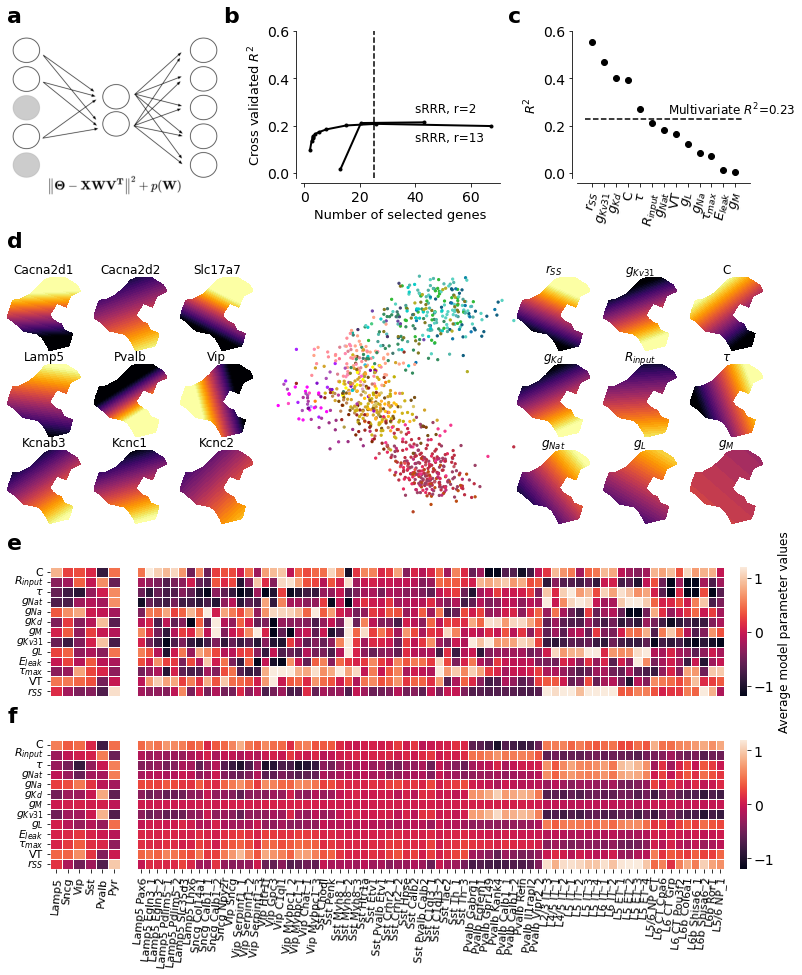

In [297]:
fig=plt.figure(figsize=(12,12))

ax_sRRR_schema, ax_sRRR_cv, ax_sRRR_pred, ax_sRRR_latent, ax_sRRR_genes, ax_sRRR_model_params, ax_df_sbip_fam, ax_df_sbip_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype = create_alternative_figure_4(fig)

dims_to_show=[2,5,6,12]

ax_sRRR_schema.imshow(img)
ax_sRRR_schema.set_xticks([])
ax_sRRR_schema.set_yticks([])
sns.despine(ax=ax_sRRR_schema, left=True, bottom=True)
#ax_sRRR_schema.set_title('sRRR schema', fontsize=14)

ax_sRRR_cv.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax_sRRR_cv.plot(n_13[1:], cr_13[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax_sRRR_cv.set_ylim([-0.02,0.6])
ax_sRRR_cv.set_xlabel('Number of selected genes', fontsize = 13)
ax_sRRR_cv.set_ylabel(r'Cross validated $R^2$', fontsize = 13)
#ax_sRRR_cv.set_title('sRRR', fontsize = 14)
# ax_sRRR_cv.tick_params(axis='both', which='major', labelsize=12)
# ax_sRRR_cv.tick_params(axis='both', which='minor', labelsize=12)
ax_sRRR_cv.vlines(x=25, ymin=ax_sRRR_cv.get_ylim()[0], ymax=ax_sRRR_cv.get_ylim()[1], linestyles='dashed', color='black')
ax_sRRR_cv.annotate('sRRR, r=13', (40, np.max(cr_13)-0.08), fontsize=12)
ax_sRRR_cv.annotate('sRRR, r=2', (40, np.max(cr_2)+0.05), fontsize=12)

adjust_spines(ax_sRRR_cv,['bottom', 'left'])

order=np.argsort(sRRR_2_ind_score)[::-1]
ax_sRRR_pred.scatter(range(len(model_param_names)), sRRR_2_ind_score[order], color='black')
ax_sRRR_pred.hlines(sRRR_2_multivar_score,
          xmin=ax_sRRR_pred.get_xlim()[0],
          xmax=ax_sRRR_pred.get_xlim()[1],
          linestyle='dashed',
          color='black')
ax_sRRR_pred.annotate(r'Multivariate $R^2$={0:.2f}'.format(sRRR_2_multivar_score),
           (ax_sRRR_pred.get_xlim()[0]+1.05*(ax_sRRR_pred.get_xlim()[1]-ax_sRRR_pred.get_xlim()[0])/2,
            sRRR_2_multivar_score+0.02),
            fontsize=12)
ax_sRRR_pred.set_ylim([-0.02,0.6])
ax_sRRR_pred.set_ylabel(r'$R^2$', fontsize=13)
ax_sRRR_pred.set_xticks(range(len(model_param_names)))
adjust_spines(ax_sRRR_pred,['bottom', 'left'])
ax_sRRR_pred.set_xticklabels(model_param_names[order], rotation='80', fontsize=13)


ax_sRRR_latent.scatter((G@w)[:,1],(G@w)[:,0], s=5, c=colors)
ax_sRRR_latent.set_xticks([])
ax_sRRR_latent.set_yticks([])
sns.despine(ax=ax_sRRR_latent, left=True, bottom=True)

gene_indices_for_visualization=[0,1,22,15,19,25,6,7,8]

for i, ax in enumerate(ax_sRRR_genes.reshape(-1)):
    latent_space_genes_sRRR(G, w, 
        gene_indices_for_visualization[i], gene_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)

model_param_names_indices_for_visualization=[-1,7,0,5,1,2,3,8,6]

for i, ax in enumerate(ax_sRRR_model_params.reshape(-1)):
    latent_space_ephys_sRRR(G, w, v, \
        model_param_names_indices_for_visualization[i], model_param_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)

sns.heatmap(df_family, xticklabels=True, linewidth=.5, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_sbip_fam)
sns.heatmap(df_type, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_sbip_ttype, cbar_kws={'label': 'Average model parameter from genes', 'anchor':(-0.2,0.5)})
ax_df_sbip_ttype.set_xticks([]);
ax_df_sbip_fam.set_xticks([]);
ax_df_sbip_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_sbip_fam.set_yticklabels(model_param_names, fontsize=11);
ax_df_sbip_ttype.collections[0].colorbar.set_label('Average model parameter values', fontsize=12)
    
sns.heatmap(df_family_sRRR, xticklabels=True, linewidth=.5, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_sRRR_fam)
sns.heatmap(df_ttype_sRRR, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_sRRR_ttype, cbar_kws={'anchor':(-0.2,0.5)})
ax_df_sRRR_fam.set_xticklabels(ax_df_sRRR_fam.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_ttype.set_xticklabels(ax_df_sRRR_ttype.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_sRRR_fam.set_yticklabels(model_param_names, fontsize=11);
    
fig.text(0, .98, 'a', fontsize=22, fontweight='bold')
fig.text(.25, .98, 'b', fontsize=22, fontweight='bold')
fig.text(.58, .98, 'c', fontsize=22, fontweight='bold')
fig.text(0, .72, 'd', fontsize=22, fontweight='bold')
fig.text(0, .37, 'e', fontsize=22, fontweight='bold')
fig.text(0, .17, 'f', fontsize=22, fontweight='bold')

plt.savefig('figures/figure_4_updated.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('figures/figure_4_updated.pdf', bbox_inches = 'tight', pad_inches = 0)

Text(0, 0.17, 'f')

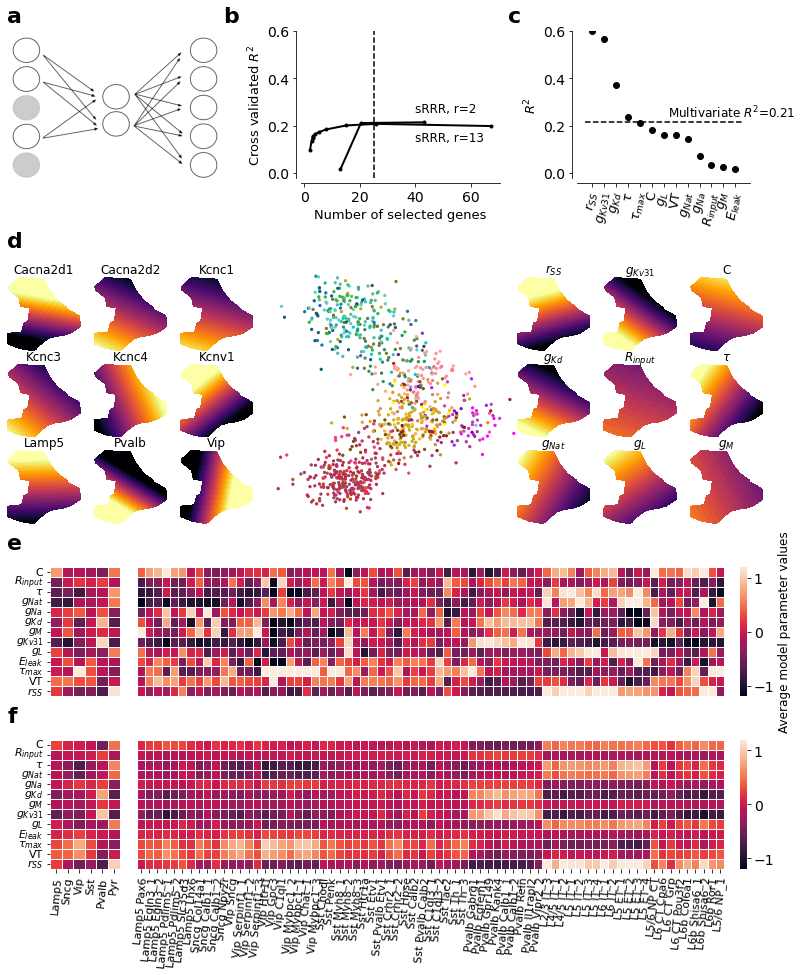

In [249]:
fig=plt.figure(figsize=(12,12))

ax_sRRR_schema, ax_sRRR_cv, ax_sRRR_pred, ax_sRRR_latent, ax_sRRR_genes, ax_sRRR_model_params, ax_df_npep_fam, ax_df_npep_ttype, ax_df_sRRR_fam, ax_df_sRRR_ttype = create_alternative_figure_4(fig)

dims_to_show=[2,5,6,12]

ax_sRRR_schema.imshow(img)
ax_sRRR_schema.set_xticks([])
ax_sRRR_schema.set_yticks([])
sns.despine(ax=ax_sRRR_schema, left=True, bottom=True)
#ax_sRRR_schema.set_title('sRRR schema', fontsize=14)

ax_sRRR_cv.plot(n_2, cr_2, '.-', c = np.array([0, 0, 0])/256, linewidth=2)
ax_sRRR_cv.plot(n_13[1:], cr_13[1:], '.-', c = np.array([0, 0, 0]) / 256, linewidth=2)
ax_sRRR_cv.set_ylim([-0.02,0.6])
ax_sRRR_cv.set_xlabel('Number of selected genes', fontsize = 13)
ax_sRRR_cv.set_ylabel(r'Cross validated $R^2$', fontsize = 13)
#ax_sRRR_cv.set_title('sRRR', fontsize = 14)
# ax_sRRR_cv.tick_params(axis='both', which='major', labelsize=12)
# ax_sRRR_cv.tick_params(axis='both', which='minor', labelsize=12)
ax_sRRR_cv.vlines(x=25, ymin=ax_sRRR_cv.get_ylim()[0], ymax=ax_sRRR_cv.get_ylim()[1], linestyles='dashed', color='black')
ax_sRRR_cv.annotate('sRRR, r=13', (40, np.max(cr_13)-0.08), fontsize=12)
ax_sRRR_cv.annotate('sRRR, r=2', (40, np.max(cr_2)+0.05), fontsize=12)

adjust_spines(ax_sRRR_cv,['bottom', 'left'])

order=np.argsort(sRRR_2_ind_score)[::-1]
ax_sRRR_pred.scatter(range(len(model_param_names)), sRRR_2_ind_score[order], color='black')
ax_sRRR_pred.hlines(sRRR_2_multivar_score,
          xmin=ax_sRRR_pred.get_xlim()[0],
          xmax=ax_sRRR_pred.get_xlim()[1],
          linestyle='dashed',
          color='black')
ax_sRRR_pred.annotate(r'Multivariate $R^2$={0:.2f}'.format(sRRR_2_multivar_score),
           (ax_sRRR_pred.get_xlim()[0]+1.05*(ax_sRRR_pred.get_xlim()[1]-ax_sRRR_pred.get_xlim()[0])/2,
            sRRR_2_multivar_score+0.02),
            fontsize=12)
ax_sRRR_pred.set_ylim([-0.02,0.6])
ax_sRRR_pred.set_ylabel(r'$R^2$', fontsize=13)
ax_sRRR_pred.set_xticks(range(len(model_param_names)))
adjust_spines(ax_sRRR_pred,['bottom', 'left'])
ax_sRRR_pred.set_xticklabels(model_param_names[order], rotation='80', fontsize=13)


ax_sRRR_latent.scatter((G@w)[:,1],(G@w)[:,0], s=5, c=colors)
ax_sRRR_latent.set_xticks([])
ax_sRRR_latent.set_yticks([])
sns.despine(ax=ax_sRRR_latent, left=True, bottom=True)

gene_indices_for_visualization=[1,2,8,9,10,13,14,17,24]

for i, ax in enumerate(ax_sRRR_genes.reshape(-1)):
    latent_space_genes_sRRR(G, w, 
        gene_indices_for_visualization[i], gene_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)

model_param_names_indices_for_visualization=[-1,7,0,5,1,2,3,8,6]

for i, ax in enumerate(ax_sRRR_model_params.reshape(-1)):
    latent_space_ephys_sRRR(G, w, v, \
        model_param_names_indices_for_visualization[i], model_param_names, axis=ax)
    sns.despine(ax=ax, left=True, bottom=True)

sns.heatmap(df_family, xticklabels=True, linewidth=.5, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_npep_fam)
sns.heatmap(df_type, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_npep_ttype, cbar_kws={'label': 'Average model parameter from genes', 'anchor':(-0.2,0.5)})
ax_df_npep_ttype.set_xticks([]);
ax_df_npep_fam.set_xticks([]);
ax_df_npep_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_npep_fam.set_yticklabels(model_param_names, fontsize=11);
ax_df_npep_ttype.collections[0].colorbar.set_label('Average model parameter values', fontsize=12)
    
sns.heatmap(df_family_sRRR, xticklabels=True, linewidth=.5, vmin=-1.2, vmax=1.2, cbar=False, ax=ax_df_sRRR_fam)
sns.heatmap(df_ttype_sRRR, xticklabels=True, linewidth=.5, yticklabels=[], vmin=-1.2, vmax=1.2, ax=ax_df_sRRR_ttype, cbar_kws={'anchor':(-0.2,0.5)})
ax_df_sRRR_fam.set_xticklabels(ax_df_sRRR_fam.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_ttype.set_xticklabels(ax_df_sRRR_ttype.get_xticklabels(), fontsize=11, rotation=85);
ax_df_sRRR_fam.set_yticks([.5,1.5,2.5,3.5,4.5,5.5,6.5,7.5,8.5,9.5,10.5,11.5,12.5])
ax_df_sRRR_fam.set_yticklabels(model_param_names, fontsize=11);
    
fig.text(0, .98, 'a', fontsize=22, fontweight='bold')
fig.text(.25, .98, 'b', fontsize=22, fontweight='bold')
fig.text(.58, .98, 'c', fontsize=22, fontweight='bold')
fig.text(0, .72, 'd', fontsize=22, fontweight='bold')
fig.text(0, .37, 'e', fontsize=22, fontweight='bold')
fig.text(0, .17, 'f', fontsize=22, fontweight='bold')

# plt.savefig('figures/figure_4_updated.png', bbox_inches = 'tight', pad_inches = 0)
# plt.savefig('figures/figure_4_updated.pdf', bbox_inches = 'tight', pad_inches = 0)

### Figure 6

Average family simulations on the tSNE

In [136]:
# Get average family simulations, from fitting with sbip
x_Pvalb=M1_model._run_HH_model(highest_posterior_samples[celltype_Pvalb.values,:].mean(axis=0))
x_Vip=M1_model._run_HH_model(highest_posterior_samples[celltype_Vip.values,:].mean(axis=0))
x_Sst=M1_model._run_HH_model(highest_posterior_samples[celltype_Sst.values,:].mean(axis=0))
x_Lamp5=M1_model._run_HH_model(highest_posterior_samples[celltype_Lamp5.values,:].mean(axis=0))
x_Pyr=M1_model._run_HH_model(highest_posterior_samples[celltype_Pyr.values,:].mean(axis=0))
x_Sncg=M1_model._run_HH_model(highest_posterior_samples[celltype_Sncg.values,:].mean(axis=0))

In [137]:
# Get average family simulations, from utilizing genes and predicting fitted model parameter distributions (test data only)
x_g_Pvalb=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Pvalb[ind].values & test_ids,:].mean(axis=0))
x_g_Vip=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Vip[ind].values & test_ids,:].mean(axis=0))
x_g_Sst=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Sst[ind].values & test_ids,:].mean(axis=0))
x_g_Lamp5=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Lamp5[ind].values & test_ids,:].mean(axis=0))
x_g_Pyr=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Pyr[ind].values & test_ids,:].mean(axis=0))
x_g_Sncg=M1_model._run_HH_model(highest_posterior_samples_gt[celltype_Sncg[ind].values & test_ids,:].mean(axis=0))

In [135]:
# Get average family simulations, from utilizing genes and predicting fitted model parameter distributions with sRRR (for entire dataset, based on good cv results)
x_g_Pvalb_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Pvalb[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)
x_g_Vip_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Vip[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)
x_g_Sst_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Sst[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)
x_g_Lamp5_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Lamp5[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)
x_g_Pyr_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Pyr[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)
x_g_Sncg_sRRR=M1_model._run_HH_model(((G.numpy()@w@v.T)[celltype_Sncg[ind].values,:].mean(axis=0))*THETA_std+THETA_mean)

Alternatively, from family 1-hot encoding

In [138]:
family_encoding=np.zeros((Xo.shape[0], 6))
family_encoding[celltype_Pvalb,0]=1
family_encoding[celltype_Sst,1]=1
family_encoding[celltype_Vip,2]=1
family_encoding[celltype_Lamp5,3]=1
family_encoding[celltype_Pyr,4]=1
family_encoding[celltype_Sncg,5]=1

In [139]:
# transform
highest_posterior_samples_ft=(highest_posterior_samples_ft_standardized+THETA_train_mean.numpy())*\
        THETA_std + THETA_mean

In [140]:
# Get average family simulations, from utilizing family 1-hot encoding and predicting model parameter distributions (test data only)
x_f_Pvalb=M1_model._run_HH_model(highest_posterior_samples_ft[0,:])
x_f_Vip=M1_model._run_HH_model(highest_posterior_samples_ft[2,:])
x_f_Sst=M1_model._run_HH_model(highest_posterior_samples_ft[1,:])
x_f_Lamp5=M1_model._run_HH_model(highest_posterior_samples_ft[3,:])
x_f_Pyr=M1_model._run_HH_model(highest_posterior_samples_ft[4,:])
x_f_Sncg=M1_model._run_HH_model(highest_posterior_samples_ft[5,:])

We've omitted Sncg in these plots, they give reasonable results, but they're few cells.

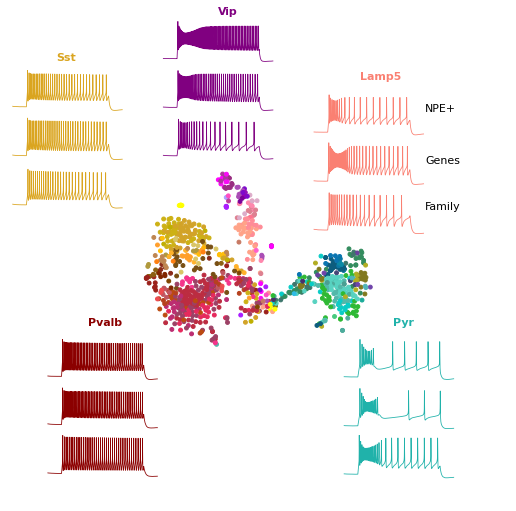

In [142]:
width, height= .24, .09
lw=.8

# ax=axes[0]
# ax_g=axes[1]

fig, ax=plt.subplots(1,1,figsize=(9,9))

ax.scatter(Z[:,0], Z[:,1], s=15, c=colors, zorder=1)
ax.set_xlim([ax.get_xlim()[0]-30, ax.get_xlim()[1]+30])
ax.set_ylim([ax.get_ylim()[0]-30, ax.get_ylim()[1]+30])

ax_Pvalb=ax.inset_axes([0.07, .25,width,height], zorder=0)
ax_Pvalb.plot(x_Pvalb['time'], x_Pvalb['data'][0,0,:], lw=lw, c='darkred')
ax_g_Pvalb=ax.inset_axes([0.07,.15,width,height], zorder=0)
ax_g_Pvalb.plot(x_g_Pvalb['time'], x_g_Pvalb['data'][0,0,:], lw=lw, c='darkred')
ax_f_Pvalb=ax.inset_axes([0.07,.05,width,height], zorder=0)
ax_f_Pvalb.plot(x_f_Pvalb['time'], x_f_Pvalb['data'][0,0,:], lw=lw, c='darkred')
for ax_ in [ax_g_Pvalb, ax_f_Pvalb]:
    ax_.set_xlim([ax_Pvalb.get_xlim()[0],ax_Pvalb.get_xlim()[1]])
    ax_.set_ylim([ax_Pvalb.get_ylim()[0],ax_Pvalb.get_ylim()[1]])
    
ax_Vip=ax.inset_axes([.3,.9,width,height], zorder=0)
ax_Vip.plot(x_Vip['time'], x_Vip['data'][0,0,:], lw=lw, c='purple')
ax_g_Vip=ax.inset_axes([.3,.8,width,height], zorder=0)
ax_g_Vip.plot(x_g_Vip['time'], x_g_Vip['data'][0,0,:], lw=lw, c='purple')
ax_f_Vip=ax.inset_axes([.3,.7,width,height], zorder=0)
ax_f_Vip.plot(x_f_Vip['time'], x_f_Vip['data'][0,0,:], lw=lw, c='purple')
for ax_ in [ax_g_Vip, ax_f_Vip]:
    ax_.set_xlim([ax_Vip.get_xlim()[0],ax_Vip.get_xlim()[1]])
    ax_.set_ylim([ax_Vip.get_ylim()[0],ax_Vip.get_ylim()[1]])


ax_Sst=ax.inset_axes([0,.8,width,height], zorder=0)
ax_Sst.plot(x_Sst['time'], x_Sst['data'][0,0,:], lw=lw, c='goldenrod')
ax_g_Sst=ax.inset_axes([0,.7,width,height], zorder=0)
ax_g_Sst.plot(x_g_Sst['time'], x_g_Sst['data'][0,0,:], lw=lw, c='goldenrod')
ax_f_Sst=ax.inset_axes([0,.6,width,height], zorder=0)
ax_f_Sst.plot(x_f_Sst['time'], x_f_Sst['data'][0,0,:], lw=lw, c='goldenrod')
for ax_ in [ax_g_Sst, ax_f_Sst]:
    ax_.set_xlim([ax_Sst.get_xlim()[0],ax_Sst.get_xlim()[1]])
    ax_.set_ylim([ax_Sst.get_ylim()[0],ax_Sst.get_ylim()[1]])

ax_Lamp5=ax.inset_axes([.6,.75,width,height], zorder=0)
ax_Lamp5.plot(x_Lamp5['time'], x_Lamp5['data'][0,0,:], lw=lw, c='salmon')
ax_g_Lamp5=ax.inset_axes([.6,.65,width,height], zorder=0)
ax_g_Lamp5.plot(x_g_Lamp5['time'], x_g_Lamp5['data'][0,0,:], lw=lw, c='salmon')
ax_f_Lamp5=ax.inset_axes([.6,.55,width,height], zorder=0)
ax_f_Lamp5.plot(x_f_Lamp5['time'], x_f_Lamp5['data'][0,0,:], lw=lw, c='salmon')
for ax_ in [ax_g_Lamp5, ax_f_Lamp5]:
    ax_.set_xlim([ax_Lamp5.get_xlim()[0],ax_Lamp5.get_xlim()[1]])
    ax_.set_ylim([ax_Lamp5.get_ylim()[0],ax_Lamp5.get_ylim()[1]])

ax_Pyr=ax.inset_axes([.66,.25,width,height], zorder=0)
ax_Pyr.plot(x_Pyr['time'], x_Pyr['data'][0,0,:], lw=lw, c='lightseagreen')
ax_g_Pyr=ax.inset_axes([.66,.15,width,height], zorder=0)
ax_g_Pyr.plot(x_g_Pyr['time'], x_g_Pyr['data'][0,0,:], lw=lw, c='lightseagreen')
ax_f_Pyr=ax.inset_axes([.66,0.05,width,height], zorder=0)
ax_f_Pyr.plot(x_f_Pyr['time'], x_f_Pyr['data'][0,0,:], lw=lw, c='lightseagreen')
for ax_ in [ax_g_Pyr, ax_f_Pyr]:
    ax_.set_xlim([ax_Pyr.get_xlim()[0],ax_Pyr.get_xlim()[1]])
    ax_.set_ylim([ax_Pyr.get_ylim()[0],ax_Pyr.get_ylim()[1]])

for ax_ in [ax, ax_Pvalb, ax_g_Pvalb, ax_f_Pvalb, ax_Vip, ax_g_Vip, ax_f_Vip, ax_Sst, ax_g_Sst, ax_f_Sst,
            ax_Lamp5, ax_g_Lamp5, ax_f_Lamp5,
            ax_Pyr, ax_g_Pyr, ax_f_Pyr]:
    ax_.set_xticks([])
    ax_.set_yticks([])
    sns.despine(ax=ax_, left=True, bottom=True)

fig.text(0.77,.73,'NPE+', fontsize=11, color='black')
fig.text(0.77,.65,'Genes', fontsize=11, color='black')
fig.text(0.77,.58,'Family', fontsize=11, color='black')

fig.text(0.25, .4, 'Pvalb', fontsize=11, color='darkred', fontweight='bold')
fig.text(.45, .88, 'Vip', fontsize=11, color='purple', fontweight='bold')
fig.text(.2, .81, 'Sst', fontsize=11, color='goldenrod', fontweight='bold')
fig.text(.67, .78, 'Lamp5', fontsize=11, color='salmon', fontweight='bold')
fig.text(.72, .4, 'Pyr', fontsize=11, color='lightseagreen', fontweight='bold')
    
plt.savefig('figures/figure_5.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('figures/figure_5.pdf', bbox_inches = 'tight', pad_inches = 0)

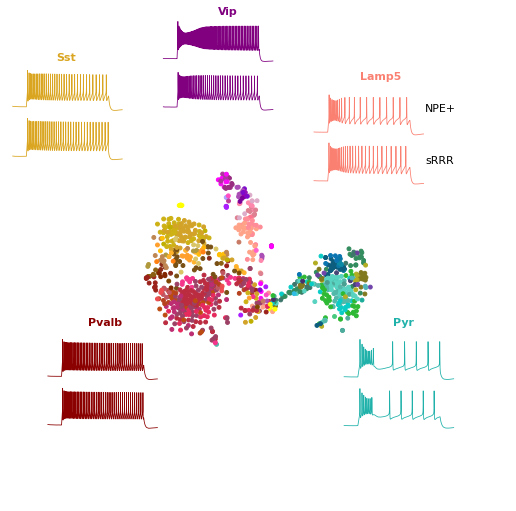

In [143]:
width, height= .24, .09
lw=.8

# ax=axes[0]
# ax_g=axes[1]

fig, ax=plt.subplots(1,1,figsize=(9,9))

ax.scatter(Z[:,0], Z[:,1], s=15, c=colors, zorder=1)
ax.set_xlim([ax.get_xlim()[0]-30, ax.get_xlim()[1]+30])
ax.set_ylim([ax.get_ylim()[0]-30, ax.get_ylim()[1]+30])

ax_Pvalb=ax.inset_axes([0.07, .25,width,height], zorder=0)
ax_Pvalb.plot(x_Pvalb['time'], x_Pvalb['data'][0,0,:], lw=lw, c='darkred')
ax_g_Pvalb=ax.inset_axes([0.07,.15,width,height], zorder=0)
ax_g_Pvalb.plot(x_g_Pvalb_sRRR['time'], x_g_Pvalb_sRRR['data'][0,0,:], lw=lw, c='darkred')
ax_g_Pvalb.set_xlim([ax_Pvalb.get_xlim()[0],ax_Pvalb.get_xlim()[1]])
ax_g_Pvalb.set_ylim([ax_Pvalb.get_ylim()[0],ax_Pvalb.get_ylim()[1]])
    
ax_Vip=ax.inset_axes([.3,.9,width,height], zorder=0)
ax_Vip.plot(x_Vip['time'], x_Vip['data'][0,0,:], lw=lw, c='purple')
ax_g_Vip=ax.inset_axes([.3,.8,width,height], zorder=0)
ax_g_Vip.plot(x_g_Vip_sRRR['time'], x_g_Vip_sRRR['data'][0,0,:], lw=lw, c='purple')
ax_g_Vip.set_xlim([ax_Vip.get_xlim()[0],ax_Vip.get_xlim()[1]])
ax_g_Vip.set_ylim([ax_Vip.get_ylim()[0],ax_Vip.get_ylim()[1]])


ax_Sst=ax.inset_axes([0,.8,width,height], zorder=0)
ax_Sst.plot(x_Sst['time'], x_Sst['data'][0,0,:], lw=lw, c='goldenrod')
ax_g_Sst=ax.inset_axes([0,.7,width,height], zorder=0)
ax_g_Sst.plot(x_g_Sst_sRRR['time'], x_g_Sst_sRRR['data'][0,0,:], lw=lw, c='goldenrod')
ax_g_Sst.set_xlim([ax_Sst.get_xlim()[0],ax_Sst.get_xlim()[1]])
ax_g_Sst.set_ylim([ax_Sst.get_ylim()[0],ax_Sst.get_ylim()[1]])

ax_Lamp5=ax.inset_axes([.6,.75,width,height], zorder=0)
ax_Lamp5.plot(x_Lamp5['time'], x_Lamp5['data'][0,0,:], lw=lw, c='salmon')
ax_g_Lamp5=ax.inset_axes([.6,.65,width,height], zorder=0)
ax_g_Lamp5.plot(x_g_Lamp5_sRRR['time'], x_g_Lamp5_sRRR['data'][0,0,:], lw=lw, c='salmon')
ax_g_Lamp5.set_xlim([ax_Lamp5.get_xlim()[0],ax_Lamp5.get_xlim()[1]])
ax_g_Lamp5.set_ylim([ax_Lamp5.get_ylim()[0],ax_Lamp5.get_ylim()[1]])

ax_Pyr=ax.inset_axes([.66,.25,width,height], zorder=0)
ax_Pyr.plot(x_Pyr['time'], x_Pyr['data'][0,0,:], lw=lw, c='lightseagreen')
ax_g_Pyr=ax.inset_axes([.66,.15,width,height], zorder=0)
ax_g_Pyr.plot(x_g_Pyr_sRRR['time'], x_g_Pyr_sRRR['data'][0,0,:], lw=lw, c='lightseagreen')
ax_g_Pyr.set_xlim([ax_Pyr.get_xlim()[0],ax_Pyr.get_xlim()[1]])
ax_g_Pyr.set_ylim([ax_Pyr.get_ylim()[0],ax_Pyr.get_ylim()[1]])

for ax_ in [ax, ax_Pvalb, ax_g_Pvalb, ax_Vip, ax_g_Vip, ax_Sst, ax_g_Sst,
            ax_Lamp5, ax_g_Lamp5,
            ax_Pyr, ax_g_Pyr]:
    ax_.set_xticks([])
    ax_.set_yticks([])
    sns.despine(ax=ax_, left=True, bottom=True)

fig.text(0.77,.73,'NPE+', fontsize=11, color='black')
fig.text(0.77,.65,'sRRR', fontsize=11, color='black')

fig.text(0.25, .4, 'Pvalb', fontsize=11, color='darkred', fontweight='bold')
fig.text(.45, .88, 'Vip', fontsize=11, color='purple', fontweight='bold')
fig.text(.2, .81, 'Sst', fontsize=11, color='goldenrod', fontweight='bold')
fig.text(.67, .78, 'Lamp5', fontsize=11, color='salmon', fontweight='bold')
fig.text(.72, .4, 'Pyr', fontsize=11, color='lightseagreen', fontweight='bold')
    
plt.savefig('figures/figure_5_alternative.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('figures/figure_5_alternative.pdf', bbox_inches = 'tight', pad_inches = 0)

### Possibly supplementary

Do we lose something by introducing noise to the summary statistics in our training data? When the model is _not_ misspecified, does the posterior change much between training frameworks?

In [919]:
THETAS={
    'sbi':{'highest posterior samples':{}, '10 random samples':{}},
    'sbi+':{'highest posterior samples':{}, '10 random samples':{}},
}

In [ ]:
# simulations within the 30 to 70 percentiles of model misspefication
sim_indices_30_70=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[
    int(E_distances_prior.shape[0]*0.3):int(E_distances_prior.shape[0]*0.7)]]

In [930]:
# 100 random simulation indices from there
perm_indices=np.random.randint(0,sim_indices_30_70.shape[0],100)

In [934]:
print('Extracting the highest posterior sample and 10 random posterior samples', 
      'for each random simulation in the 30-70 % perentiles: ')
for tr_schedule in ['sbi', 'sbi+']:
    print('\n', tr_schedule)
        
    for index in perm_indices:
        print('.', end='')
        
        if tr_schedule=='sbi':
            # sampling 10000 from the posterior
            samples=sbi_posterior.sample(
                (10000,),
                x=torch.as_tensor(stats[sim_indices_30_70[index],feature_list], dtype=float),
                show_progress_bars=False
            )
        
            # highest posterior simulation
            highest_post_sample_1=samples[
                np.argsort(
                    np.array(
                        sbi_posterior.log_prob(theta=samples, x=stats[sim_indices_30_70[index],feature_list])
                    )
                )[-1],:
            ]
        else:
            # sampling 10000 from the posterior
            samples=sbip_posterior.sample(
                (10000,),
                x=torch.as_tensor(stats[sim_indices_30_70[index],feature_list], dtype=float),
                show_progress_bars=False
            )
        
            # highest posterior simulation
            highest_post_sample_1=samples[
                np.argsort(
                    np.array(
                        sbip_posterior.log_prob(theta=samples, x=stats[sim_indices_30_70[index],feature_list])
                    )
                )[-1],:
            ]            
        
        THETAS[tr_schedule]['highest posterior samples'].update({sim_indices_30_70[index]:np.array(highest_post_sample_1)})
        THETAS[tr_schedule]['10 random samples'].update({sim_indices_30_70[index]:samples[torch.randint(10000, (10,)),:]})
        
with open('save_model_parameters/calibration_study.pickle', 'wb') as f:
    pickle.dump(THETAS, f)

Extracting the highest posterior sample and 10 random posterior samples for each random simulation in the 30-70 % perentiles: 

 sbi
....................................................................................................
 sbi+
.....................

                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 9910 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., norm_posterior=False)`. The latter will
                        result in an unnormalized `log_prob()`.


........

                        prior support. It may take a long time to collect the
                        remaining 9983 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 9966 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., nor

...............................

                        prior support. It may take a long time to collect the
                        remaining 9945 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
                        constant for `log_prob()`. However, only
                        1% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 9949 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., nor

............................

                        prior support. It may take a long time to collect the
                        remaining 9943 samples. Consider interrupting
                        (Ctrl-C) and switching to `sample_with='mcmc'`.
                        constant for `log_prob()`. However, only
                        0% posterior samples are within the
                        prior support. It may take a long time to collect the
                        remaining 9953 samples.
                        Consider interrupting (Ctrl-C) and either basing the
                        estimate of the normalizing constant on fewer samples (by
                        calling `posterior.leakage_correction(x_o,
                        num_rejection_samples=N)`, where `N` is the number of
                        samples you want to base the
                        estimate on (default N=10000), or not estimating the
                        normalizing constant at all
                        (`log_prob(..., nor

............

In [936]:
with open('save_model_parameters/calibration_study.pickle', 'rb') as f:
        THETAS = pickle.load(f)
highest_posterior_samples=np.concatenate(
    [[THETAS['sbi']['highest posterior samples'][index] for index in sim_indices_30_70[perm_indices]] for tr_schedule in THETAS]
)
posterior_samples_10_random=np.concatenate(
    [[THETAS['sbi']['10 random samples'][index].numpy() for index in sim_indices_30_70[perm_indices]] for tr_schedule in THETAS]
).reshape((100*2*10,len(model_param_names)))

In [939]:
M1_model.sim(torch.as_tensor(highest_posterior_samples, dtype=torch.float32))
np.savez('./save_sims/calibration_study_highest_posterior_samples_summ_stats.npz',
     stats=M1_model.stats.numpy()
    )
print('Highest posterior sample simulations done.')

In [938]:
M1_model.sim(torch.as_tensor(posterior_samples_10_random, dtype=torch.float32))
np.savez('./save_sims/calibration_study_samples_10_random_summ_stats.npz',
     stats=M1_model.stats.numpy()
    )
print('10 random posterior sample simulations done.')

Chunks:
........
Training set of parameters and summary statistics has been made:
parameters shape:  torch.Size([2000, 13])
summary statistics shape:  torch.Size([2000, 23])
10 random posterior sample simulations done.


In [224]:
highest_post_stats=np.load('./save_sims/calibration_study_highest_posterior_samples_summ_stats.npz')['stats']
highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((2, 100))

In [225]:
stats_repeated=np.concatenate([stats[sim_indices_30_70[perm_indices],:]]*2, axis=0)
mean=stats[sim_indices_30_70[perm_indices],:].mean(axis=0)
std=stats[sim_indices_30_70[perm_indices],:].std(axis=0)

print('Calibration study (normalization with stats mean and sd): ')
print('----------------------------------------------------------')

for i, framework in enumerate(['sbi','sbip']):
    score=np.mean(
        np.sqrt(
            np.sum(
                (
                    (highest_post_stats[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-mean)/std-\
                    (stats_repeated[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-mean)/std
                )**2,axis=1
            )
        )
    )
    score_sd=np.std(
        np.sqrt(
            np.sum(
                (
                    (highest_post_stats[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-mean)/std-\
                    (stats_repeated[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-mean)/std
                )**2,axis=1
            )
        )
    )
    print('\nFramework {}: '.format(framework), sum(highest_post_stats_nans_reshaped[i,:]), 'out of', 100,
          'failed or {:.2f} %.'.format(sum(highest_post_stats_nans_reshaped[i,:])/(100)*100),
          '\nOn simulations that were succesful we are {:.2f} +/- {:.2f} (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.'.format(score, score_sd))

NameError: name 'sim_indices_30_70' is not defined

In [961]:
stats_repeated=np.concatenate([stats[sim_indices_30_70[perm_indices],:]]*2, axis=0)
mean=stats[sim_indices_30_70[perm_indices],:].mean(axis=0)
std=stats[sim_indices_30_70[perm_indices],:].std(axis=0)

print('Calibration study (normalization with Xo mean and sd): ')
print('-------------------------------------------------------')

for i, framework in enumerate(['sbi','sbip']):
    score=np.mean(
        np.sqrt(
            np.sum(
                (
                    (highest_post_stats[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-Xo_mean)/Xo_std-\
                    (stats_repeated[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-Xo_mean)/Xo_std
                )**2,axis=1
            )
        )
    )
    score_sd=np.std(
        np.sqrt(
            np.sum(
                (
                    (highest_post_stats[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-Xo_mean)/Xo_std-\
                    (stats_repeated[100*i:100*(i+1),:][~highest_post_stats_nans[100*i:100*(i+1)],:]-Xo_mean)/Xo_std
                )**2,axis=1
            )
        )
    )
    print('\nFramework {}: '.format(framework), sum(highest_post_stats_nans_reshaped[i,:]), 'out of', 100,
          'failed or {:.2f} %.'.format(sum(highest_post_stats_nans_reshaped[i,:])/(100)*100),
          '\nOn simulations that were succesful we are {:.2f} +/- {:.2f} (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.'.format(score, score_sd))

Perfomance for each amortized posterior or each training schedule regarding drawing highest posterior samples: 
---------------------------------------------------------------------------------------------------------------

Framework sbi:  2 out of 100 failed or 2.00 %. 
On simulations that were succesful we are 1.72 +/- 2.33 (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.

Framework sbip:  2 out of 100 failed or 2.00 %. 
On simulations that were succesful we are 1.71 +/- 2.29 (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.


In [958]:
post_samples_10_random_stats=np.load('./save_sims/calibration_study_samples_10_random_summ_stats.npz')['stats']
post_samples_10_random_stats_nans=np.isnan(post_samples_10_random_stats.mean(axis=1))
post_samples_10_random_stats_nans_reshaped=post_samples_10_random_stats_nans.reshape((2, 100*10))

In [960]:
stats_repeated=np.repeat(stats[sim_indices_30_70[perm_indices],:], 10, axis=0)
stats_repeated=np.concatenate([stats_repeated]*2, axis=0)
mean=stats[sim_indices_30_70[perm_indices],:].mean(axis=0)
std=stats[sim_indices_30_70[perm_indices],:].std(axis=0)

print('Calibration study drawing 10 random posterior samples (normalization with stats mean and sd): ')
print('-----------------------------------------------')

for i, framework in enumerate(['sbi', 'sbip']):
    score=np.mean(
        np.sqrt(
            np.sum(
                (
                    (post_samples_10_random_stats[100*10*i:100*10*(i+1),:][~post_samples_10_random_stats_nans[100*10*i:100*10*(i+1)],:]-mean)/std-\
                    (stats_repeated[100*10*i:100*10*(i+1),:][~post_samples_10_random_stats_nans[100*10*i:100*10*(i+1)],:]-mean)/std
                )**2,axis=1
            )
        )
    )
    score_sd=np.std(
        np.sqrt(
            np.sum(
                (
                    (post_samples_10_random_stats[100*10*i:100*10*(i+1),:][~post_samples_10_random_stats_nans[100*10*i:100*10*(i+1)],:]-mean)/std-\
                    (stats_repeated[100*10*i:100*10*(i+1),:][~post_samples_10_random_stats_nans[100*10*i:100*10*(i+1)],:]-mean)/std
                )**2,axis=1
            )
        )
    )
    print('\nFramework {}: '.format(framework), sum(post_samples_10_random_stats_nans_reshaped[i,:]), 'out of', 100*10,
          'failed or {:.2f} %.'.format(sum(post_samples_10_random_stats_nans_reshaped[i,:])/(100*10)*100),
          '\nOn simulations that were succesful we are {:.2f} +/- {:.2f} (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.'.format(score, score_sd))

Perfomance for each amortized posterior or each training schedule regarding drawing 10 random posterior samples: 
-----------------------------------------------------------------------------------------------------------------

Framework sbi:  29 out of 1000 failed or 2.90 %. 
On simulations that were succesful we are 1.86 +/- 2.81 (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.

Framework sbip:  30 out of 1000 failed or 3.00 %. 
On simulations that were succesful we are 1.87 +/- 2.87 (mean +/- s.d.) Z-scored Euclidean ephys distance far from the experimental observation.


In [1041]:
highest_post_stats=np.load('./save_sims/calibration_study_highest_posterior_samples_summ_stats.npz')['stats']
highest_post_stats_nans=np.isnan(highest_post_stats.mean(axis=1))
highest_post_stats_nans_reshaped=highest_post_stats_nans.reshape((2, 100))

stats_repeated=np.concatenate([stats[sim_indices_30_70[perm_indices],:]]*2, axis=0)
mean=stats[sim_indices_30_70[perm_indices],:].mean(axis=0)
std=stats[sim_indices_30_70[perm_indices],:].std(axis=0)

sbi_score=np.sqrt(
    (
        (highest_post_stats[100*0:100*1,:][~highest_post_stats_nans[100*0:100*1],:]-mean)/std-\
        (stats_repeated[100*0:100*1,:][~highest_post_stats_nans[100*0:100*1],:]-mean)/std
    )**2
)

sbip_score=np.sqrt(
    (
        (highest_post_stats[100*1:100*2,:][~highest_post_stats_nans[100*1:100*2],:]-mean)/std-\
        (stats_repeated[100*1:100*2,:][~highest_post_stats_nans[100*1:100*2],:]-mean)/std
    )**2
)

In [964]:
# a simulation for which there's arguably very little model misspefication
sim_ind_ex=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[int(E_distances_prior.shape[0]*0.3)]]

In [909]:
# somewhat in between
sim_ind_ex=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[E_distances_prior.shape[0]//2]]

In [220]:
# a simulation for which there's arguably some model misspefication
sim_ind_ex=E_distances_prior_indices[np.argsort(E_distances_prior[:,-1])[int(E_distances_prior.shape[0]*0.67)]]

In [221]:
x_sim_ex=M1_model._run_HH_model(theta[sim_ind_ex,:])

In [222]:
sbi_samples=sbi_posterior.sample(
    (10000,),
    x=torch.as_tensor(stats[sim_ind_ex,feature_list], dtype=float),
)
sbi_samples=sbi_samples[
    np.argsort(
        np.array(
            sbi_posterior.log_prob(theta=sbi_samples, x=stats[sim_ind_ex,feature_list])
        )
    )[-3:],:
]
sbip_samples=sbip_posterior.sample(
    (10000,),
    x=torch.as_tensor(stats[sim_ind_ex,feature_list], dtype=float),
)
sbip_samples=sbip_samples[
    np.argsort(
        np.array(
            sbip_posterior.log_prob(theta=sbip_samples, x=stats[sim_ind_ex,feature_list])
        )
    )[-3:],:
]
x_sbi=M1_model._run_HH_model(sbi_samples.numpy())
x_sbip=M1_model._run_HH_model(sbip_samples.numpy())

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

Drawing 10000 posterior samples:   0%|          | 0/10000 [00:00<?, ?it/s]

In [223]:
def create_figure_S1(fig):
    
    if fig is None:
        fig=plt.figure(figsize=(15,7))
    else: fig = fig
    
    width, height= .07, .23
    ax_features=plt.axes([0,.52,.28,.45])
    ax_model_simulation=plt.axes([0.15,0,width,height])
    axes_sbi=np.array([[plt.axes([.31+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    axes_sbip=np.array([[plt.axes([.66+x,y,width,height]) for x in [0.,.0825,.165,.2475]] for y in [.75,.5,.25,0]])
    
    return ax_features, ax_model_simulation, axes_sbi, axes_sbip

**ToDo**: big standard deviations!!!

**ToDo**: normalized differently!!!

In [973]:
np.std(sbi_score, axis=0)[order]

array([0.02709542, 0.09191331, 0.13010399, 0.11871019, 0.1417594 ,
       0.13792208, 0.33748823, 0.2416235 , 0.36434063, 0.43769467,
       0.43010575, 0.42384464, 0.48113698, 0.45590675, 0.5907842 ,
       0.33396915, 0.32717264, 0.4673583 , 0.576132  , 0.3534489 ,
       0.517624  , 0.75153244, 0.7669778 ], dtype=float32)

In [974]:
np.std(sbip_score, axis=0)[order]

array([0.02734107, 0.09195496, 0.107827  , 0.11852676, 0.14345509,
       0.13811542, 0.31523377, 0.22663112, 0.38766894, 0.3482986 ,
       0.3140939 , 0.33070374, 0.35661212, 0.43350545, 0.5652919 ,
       0.3330549 , 0.33540133, 0.50610507, 0.6249765 , 0.35209373,
       0.38457406, 0.9615396 , 0.7053036 ], dtype=float32)

In [1046]:
lw=1

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:

WARNING    /gpfs01/berens/user/ybernaerts/.local/lib/python3.8/site-packages/sbi/analysis/plot.py:731: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if opts["labels"] == [] or opts["labels"] is None:
 [py.warnings]
  if opts["labels"] == [] or opts["labels"] is None:



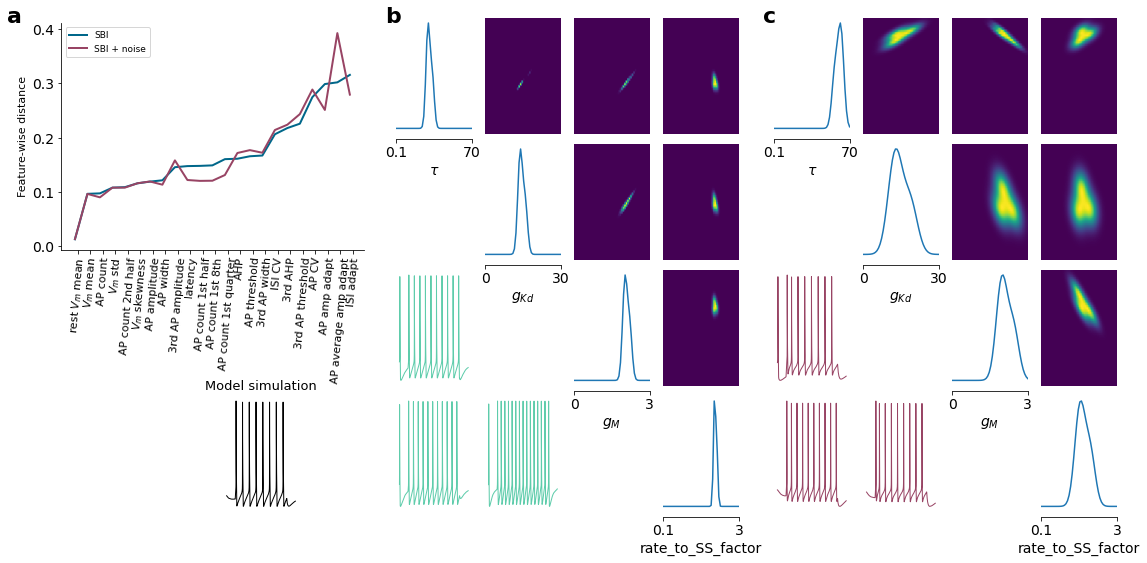

In [1048]:
fig=plt.figure(figsize=(15,7))
ax_features, ax_model_simulation, axes_sbi, axes_sbip = create_figure_S1(fig)

# Experimental observation
ax_model_simulation.plot(x_sim_ex['time'], x_sim_ex['data'][0,0,:], c='k', lw=lw)
ax_model_simulation.set_title('Model simulation', fontsize=13)
ax_model_simulation.set_xticks([])
ax_model_simulation.set_yticks([])
sns.despine(ax=ax_model_simulation, bottom=True, left=True)

# Feature-wise performances SBI vs SBI+ on simulated data
order=np.argsort(np.mean(sbi_score, axis=0))
ax_features.plot(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        np.mean(sbi_score, axis=0)[order],
        color=fancy_colors[3],
        label='SBI',
        lw=2
       )
ax_features.plot(np.linspace(0,4*len(ephys_features)+1, num=len(ephys_features)),
        np.mean(sbip_score, axis=0)[order],
        color=fancy_colors[4],
        label='SBI + noise',
        lw=2
       )
ax_features.set_xticks(np.linspace(1,4*len(ephys_features)+2, num=len(ephys_features)))
ax_features.legend(loc='upper left', fontsize=9)
ax_features.set_ylabel('Feature-wise distance', fontsize=11)
ax_features.set_xticklabels(ephys_features[order], rotation=85, fontsize=11)

# SBI pairplot
pairplot(
    sbi_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_sbi,
    upper='kde',
    diag='kde'
)

axes_sbi[3,0].plot(x_sbi['time'],x_sbi['data'][0,0,:],lw=lw,color=fancy_colors[5])
axes_sbi[2,0].plot(x_sbi['time'],x_sbi['data'][1,0,:],lw=lw,color=fancy_colors[5])
axes_sbi[3,1].plot(x_sbi['time'],x_sbi['data'][2,0,:],lw=lw,color=fancy_colors[5])

# SBI + noise pairplot
pairplot(
    sbip_samples[:,dims_to_show],
    limits=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    ticks=list(
        zip(
            np.array(prior_min)[dims_to_show],
            np.array(prior_max)[dims_to_show]
        )
    ),
    labels=np.array(model_param_names[dims_to_show]),
    points_offdiag={'markersize': 6},
    points_colors='r',
    fig=fig,
    axes=axes_sbip,
    upper='kde',
    diag='kde'
)
axes_sbip[3,0].plot(x_sbip['time'],x_sbip['data'][0,0,:],lw=lw,color=fancy_colors[4])
axes_sbip[2,0].plot(x_sbip['time'],x_sbip['data'][1,0,:],lw=lw,color=fancy_colors[4])
axes_sbip[3,1].plot(x_sbip['time'],x_sbip['data'][2,0,:],lw=lw,color=fancy_colors[4])

fig.text(-0.05, .97, 'a', fontsize=22, fontweight='bold')
fig.text(.3, .97, 'b', fontsize=22, fontweight='bold')
fig.text(.65, .97, 'c', fontsize=22, fontweight='bold')

plt.savefig('figures/figure_S1.png', bbox_inches = 'tight', pad_inches = 0)
plt.savefig('figures/figure_S1.pdf', bbox_inches = 'tight', pad_inches = 0)